In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime as DT

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import re
from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df_cities_area = pd.read_csv('cities.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
#Приведем имена столбцов к нижнему регистру, и переименуем некоторые из них

df.columns = map(str.lower, df.columns)
df.rename(columns={'cuisine style': 'cuisine_style', 'price range': 'price_range', 'number of reviews':'number_reviews'}, 
          inplace=True)


# Функция по сбору информации по каждому столбцу

def info_column(column):
    print('Число уникальных значений:', df[column].nunique(), '\n')
    print('Число упоминания каждого значения: \n',
          df[column].value_counts(), '\n')
    print('Число пустых значений в столбце:',
          (df[column].isnull()).sum(), '\n')
    return  # df.loc[:, [column]].info()

# прорисовка гистограммы исходных данных
def hist_source_data(column):
    df[column].hist(alpha=0.4, bins=100, range=(
        start_point, end_point), label='Исходные данные {}'. format(column))
    plt.legend()
    return

# type в столбцах
def type_col(col):
    list_t=[]
    for i in col:
        if type(i) not in list_t:
            list_t.append(type(i))
    return list_t
# список столбцов с новыми признаками
new_features = []
def add_new_f(col):
    if col not in new_features:
        new_features.append(col)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   50000 non-null  object 
 1   city            50000 non-null  object 
 2   cuisine_style   38410 non-null  object 
 3   ranking         50000 non-null  float64
 4   price_range     32639 non-null  object 
 5   number_reviews  46800 non-null  float64
 6   reviews         49998 non-null  object 
 7   url_ta          50000 non-null  object 
 8   id_ta           50000 non-null  object 
 9   sample          50000 non-null  int64  
 10  rating          50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [7]:
# проработаем признаки
df['cuisine_style_new'] = df['cuisine_style']

In [8]:
pattern = re.compile('\w+[&,\s,\w]*\w+')
df.loc[pd.isna(df['cuisine_style_new']) == False, 'cuisine_style_new'] = df.loc[pd.isna(
    df['cuisine_style_new']) == False, 'cuisine_style_new'].apply(lambda x: pattern.findall(x))

In [9]:
add_new_f('cuisine_style_new')

In [10]:
# обработаем price_range
df['price_range'] = df['price_range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

In [11]:
#посмотрим на number_reviews
df.number_reviews.value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number_reviews, Length: 1573, dtype: int64

In [12]:
#посмотрим на reviews
df['reviews_new'] = df['reviews']
add_new_f('reviews_new')

In [13]:
# очистим строки и оставим только отзывы
df['reviews_new'] = df.reviews.apply(lambda x: x.replace('[[], []]','Unknown') if type(x)== str else x)
df['reviews_new'] = df.reviews_new.apply(lambda x: x[2:-2] if type(x) == str and x!='Unknown' else x)
df['reviews_new'] = df.reviews_new.apply(lambda x: x.split('], [') if type(x) == str else x)
df['reviews_new'] = df.reviews_new.apply(lambda x: x[0] if type(x) == list else x)

In [14]:
# заполним пропуски значением 'Unknown'
df.loc[df['reviews_new'].isna(),'reviews_new'] = 'Unknown'

In [15]:
# создадим df.date_reviews
df['date_reviews'] = df['reviews'].str.findall('\d+/\d+/\d\d\d\d')
df['date_reviews'] = df.date_reviews.apply(
    lambda x: None if x == [] or type(x) == float else x)

In [16]:
add_new_f('date_reviews')

In [17]:
# посмотрим id_ta
# проверим на уникальность
df.id_ta.value_counts()

d10316215    2
d4748208     2
d793170      2
d697406      2
d1028622     2
            ..
d718330      1
d7159142     1
d10332859    1
d7973897     1
d2540840     1
Name: id_ta, Length: 49963, dtype: int64

<AxesSubplot:>

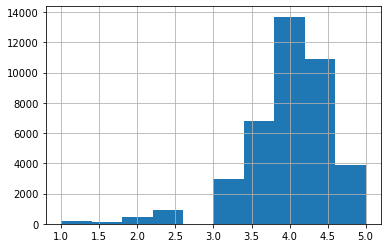

In [18]:
df[df['sample']==1].rating.hist()

In [19]:
# оставим только числовые значения и запишем в новый столбец
df['id'] = df['restaurant_id'].apply(lambda x: int(x[3:]))
add_new_f('id')

In [20]:
new_features

['cuisine_style_new', 'reviews_new', 'date_reviews', 'id']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  float64
 5   number_reviews     46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
 11  cuisine_style_new  38410 non-null  object 
 12  reviews_new        50000 non-null  object 
 13  date_reviews       41886 non-null  object 
 14  id                 50000 non-null  int64  
dtypes: float64(4), int64(2), object(9)
memory usage: 5.7+ MB


# EDA

### посмотрим на признаки

In [22]:
# посмотрим на данные с None по всем признакам
df_null = df[pd.isnull(df['cuisine_style']) & (pd.isnull(df['number_reviews'])) & (
    pd.isnull(df['price_range'])) & (df['reviews_new'] == 'Unknown')]

In [23]:
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099 entries, 7 to 49988
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      1099 non-null   object 
 1   city               1099 non-null   object 
 2   cuisine_style      0 non-null      object 
 3   ranking            1099 non-null   float64
 4   price_range        0 non-null      float64
 5   number_reviews     0 non-null      float64
 6   reviews            1098 non-null   object 
 7   url_ta             1099 non-null   object 
 8   id_ta              1099 non-null   object 
 9   sample             1099 non-null   int64  
 10  rating             1099 non-null   float64
 11  cuisine_style_new  0 non-null      object 
 12  reviews_new        1099 non-null   object 
 13  date_reviews       0 non-null      object 
 14  id                 1099 non-null   int64  
dtypes: float64(4), int64(2), object(9)
memory usage: 137.4+ KB


имеем 1099 строк с пропусками по 4-м признакам

In [24]:
# посмотрим распределение по городам
df_null.city.value_counts()

Madrid        125
Berlin        121
Paris         108
Barcelona     100
Milan          78
Hamburg        69
Vienna         61
Lisbon         44
Prague         44
Warsaw         35
Munich         33
Lyon           30
Rome           29
Oporto         26
Brussels       25
London         23
Budapest       21
Stockholm      21
Copenhagen     17
Bratislava     14
Zurich         13
Athens         12
Geneva         12
Krakow         12
Amsterdam      11
Luxembourg      4
Oslo            4
Edinburgh       3
Helsinki        2
Ljubljana       2
Name: city, dtype: int64

<AxesSubplot:>

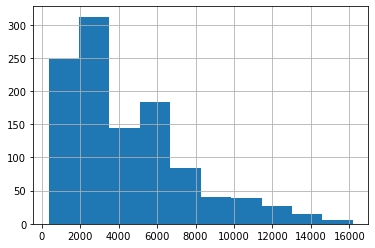

In [25]:
df_null.ranking.hist()

<AxesSubplot:>

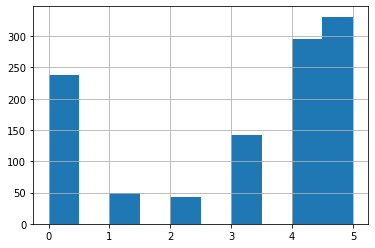

In [26]:
df_null.rating.hist()

<ipython-input-27-9cf0dba4537d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


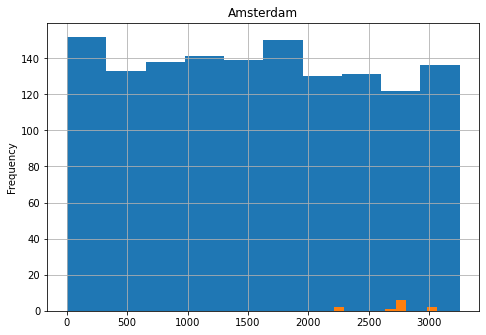

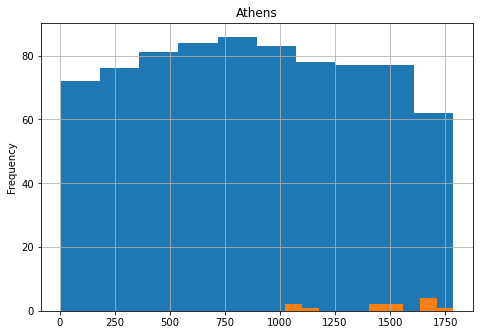

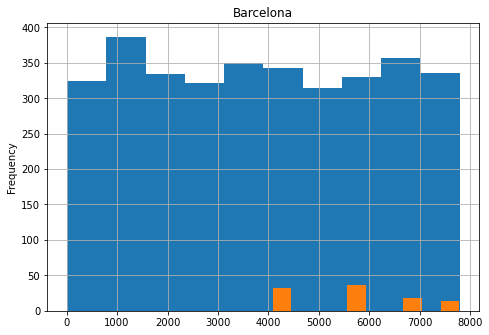

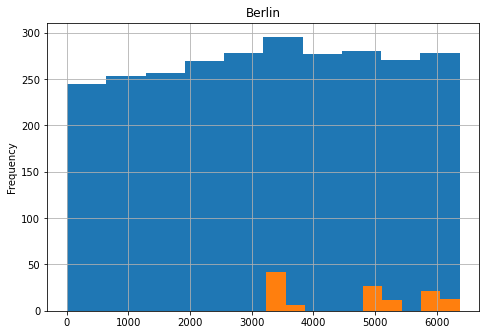

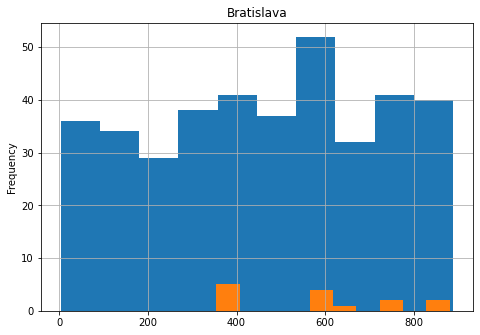

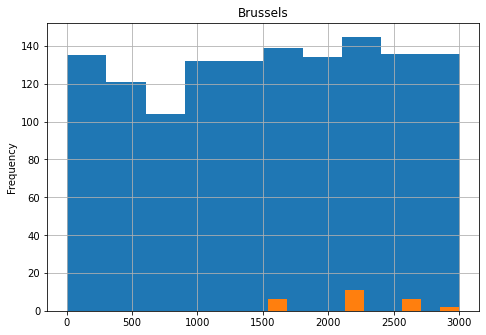

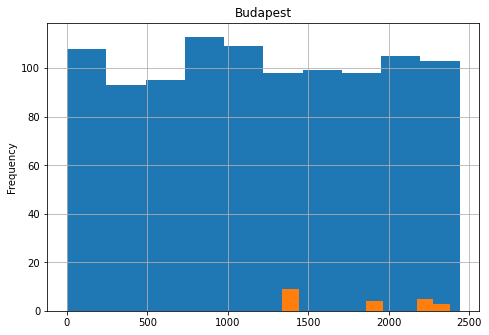

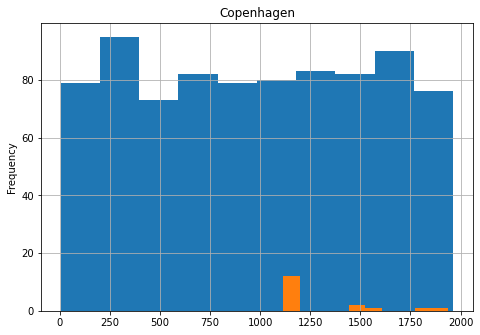

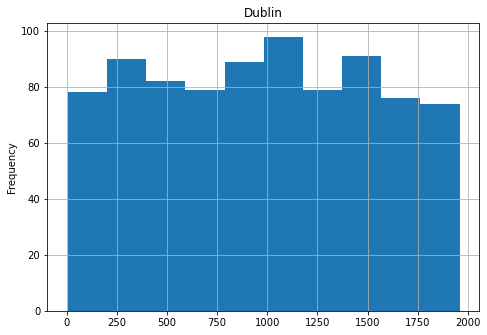

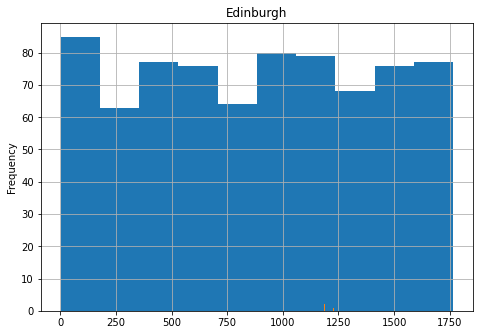

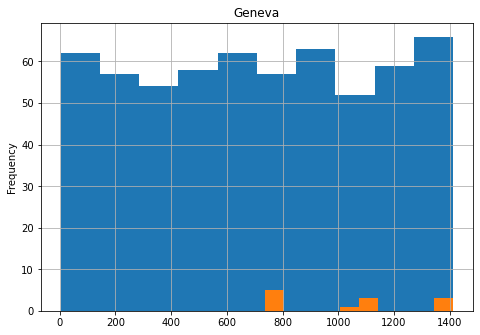

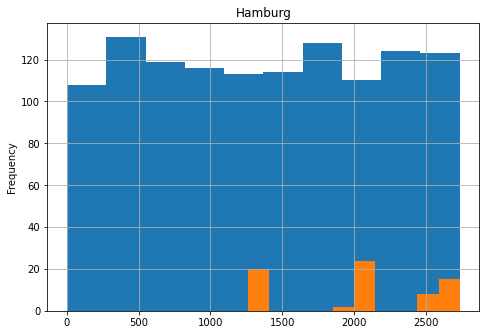

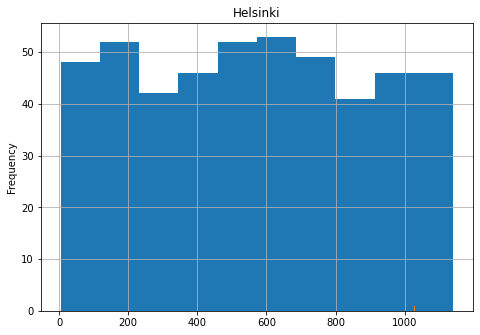

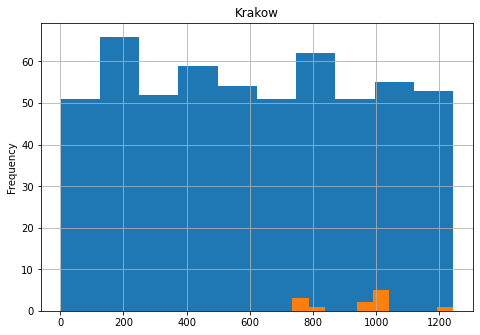

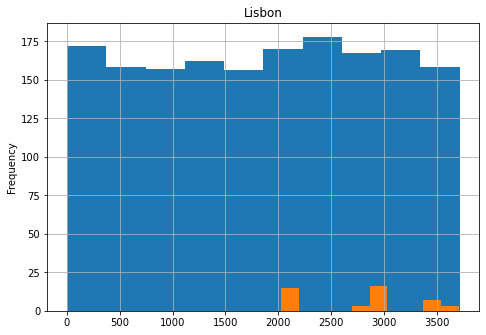

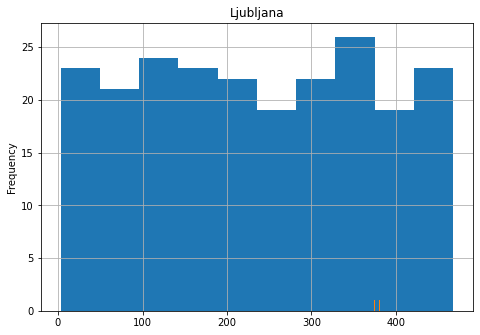

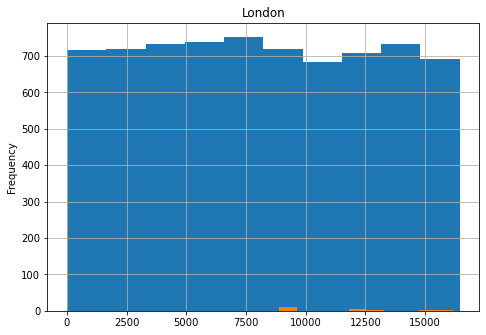

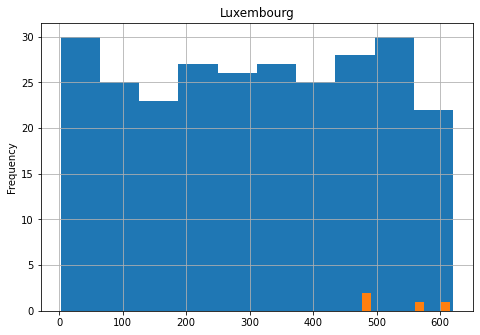

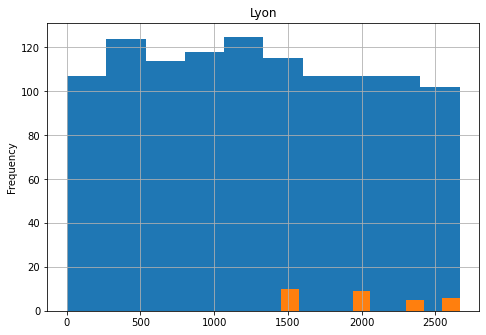

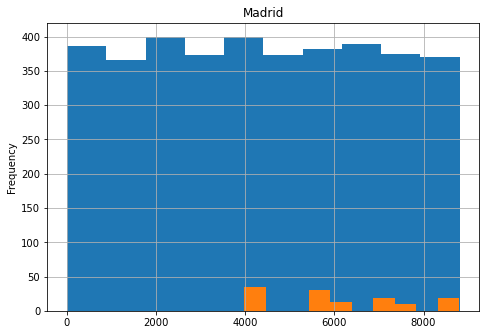

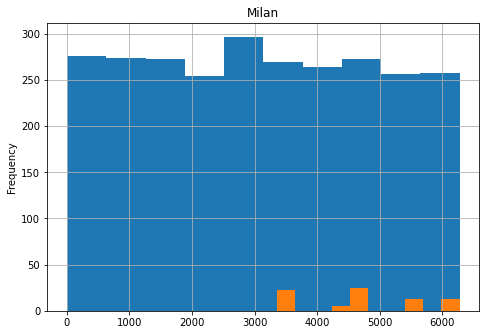

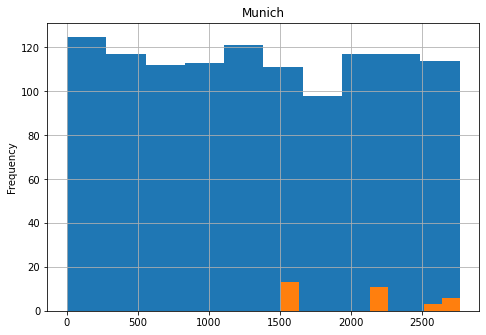

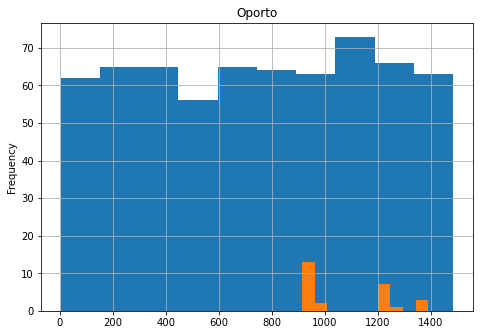

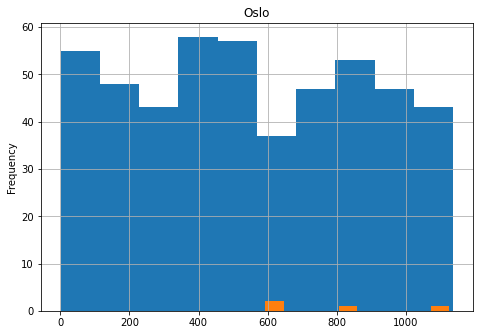

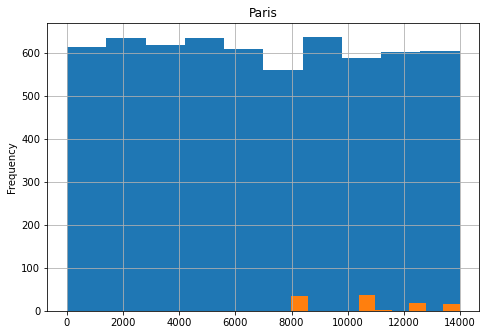

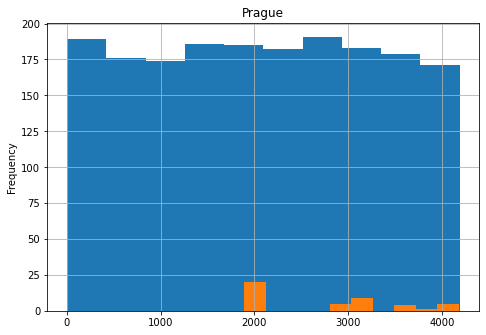

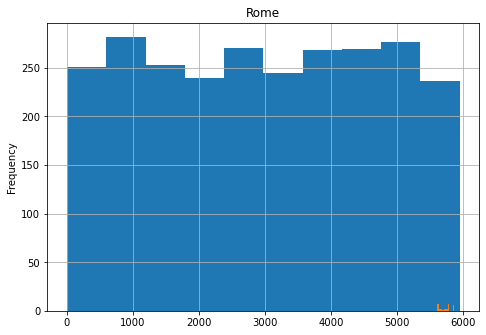

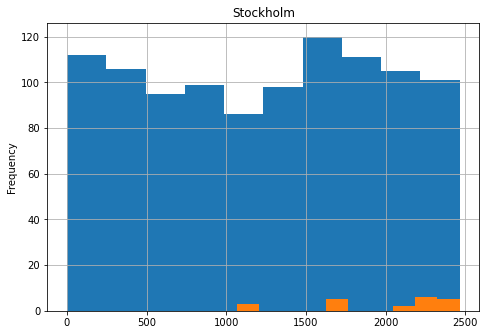

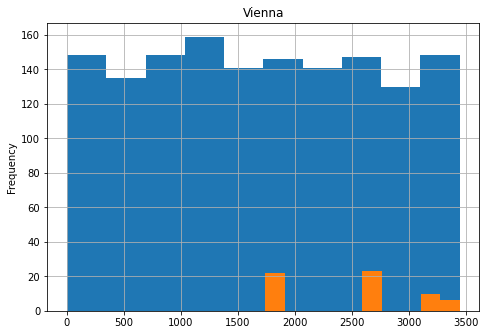

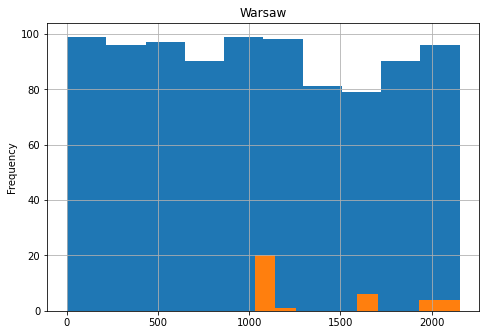

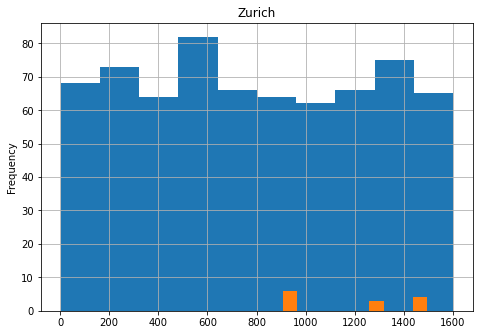

In [27]:
city_list = sorted(list(df.city.value_counts().index))
for i in city_list:
    fig, ax = plt.subplots()
    axes = fig.add_axes([0, 0, 1, 1])
    display(df[df['city']==i]['ranking'].plot(kind = 'hist', grid = True, title = i))

    display(df_null[df_null['city']==i]['ranking'].plot(kind = 'hist', grid = True, title = i))
    

In [28]:
# посмотрим на данные без None
df_no_null = df.copy()
df_no_null = df_no_null.dropna()

In [29]:
# возьмем эти рестораны как "эталонные" у которых, предположительно, все данные соответсвуют реальности
# пометим их
df_no_null['real_data'] = 1
df['real_data'] = df_no_null['real_data']
df['real_data'] = df['real_data'].fillna(0)
add_new_f('real_data')

<ipython-input-30-06ce47b54c3c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


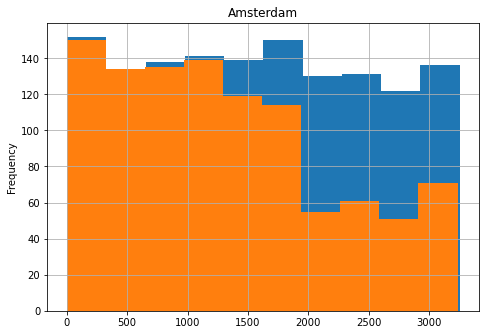

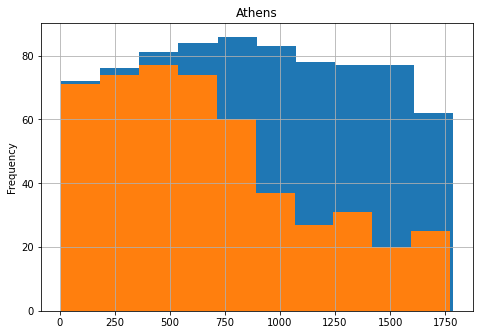

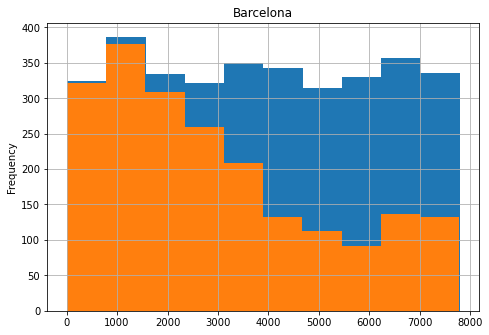

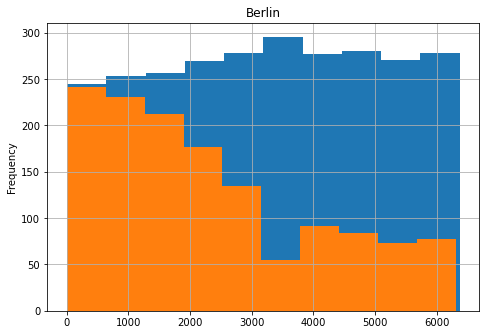

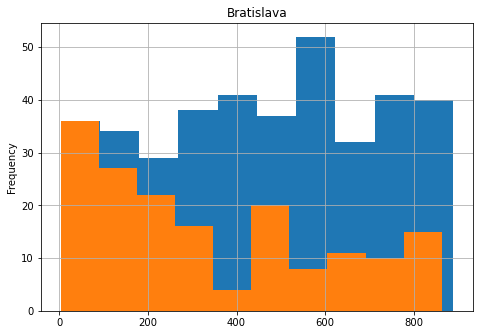

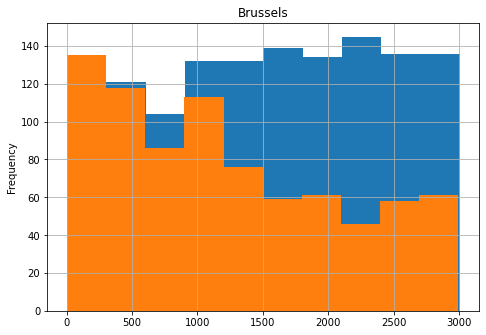

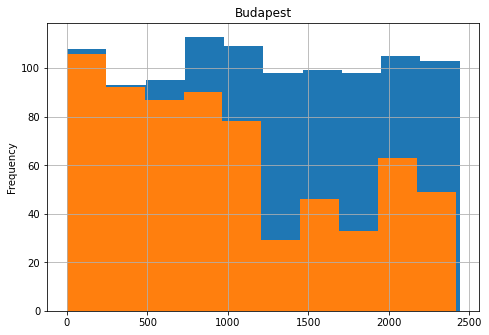

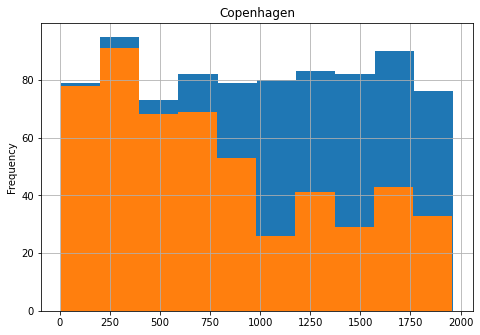

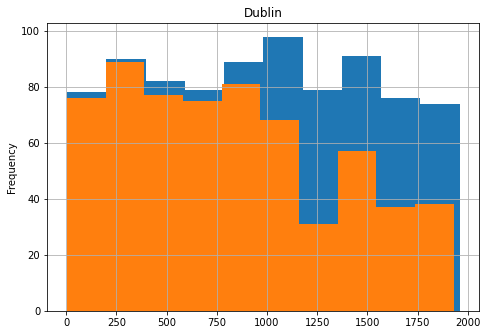

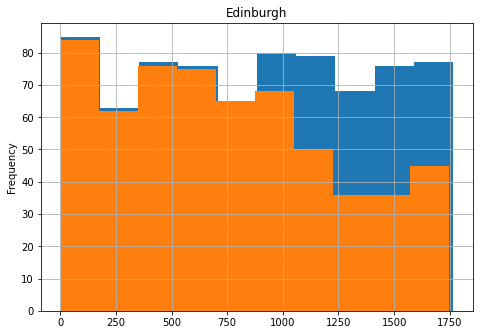

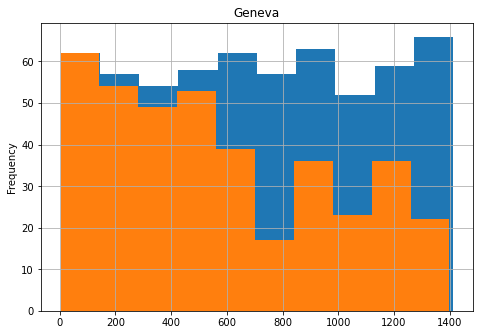

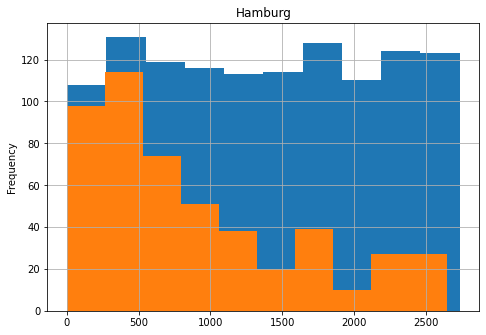

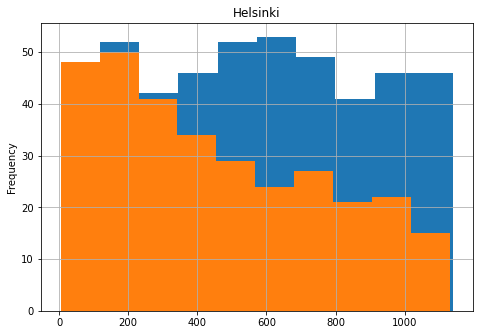

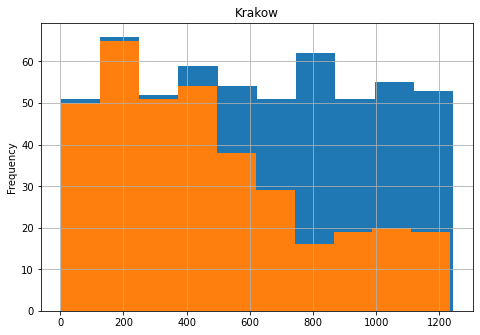

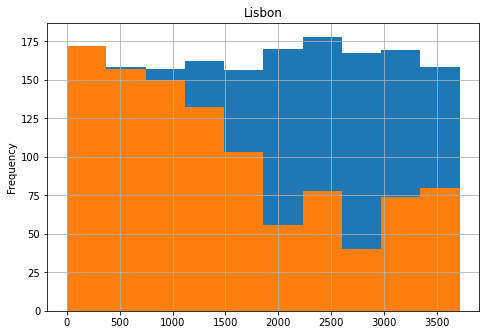

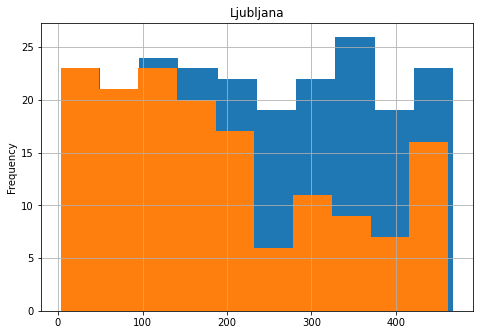

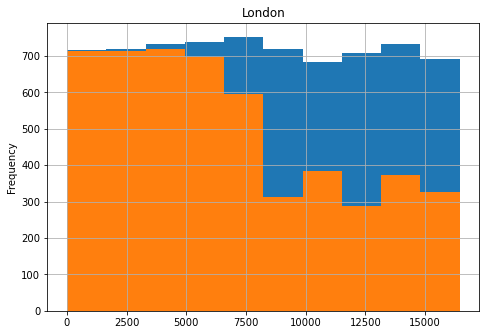

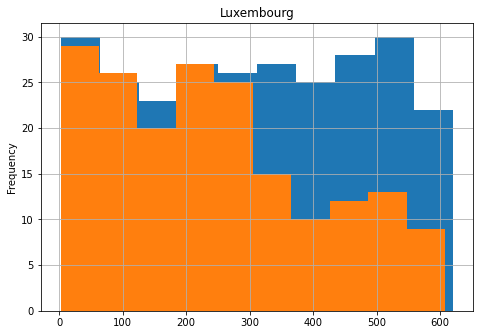

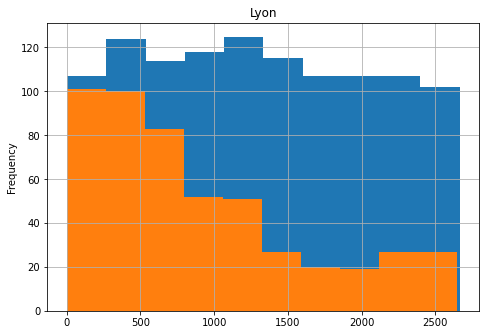

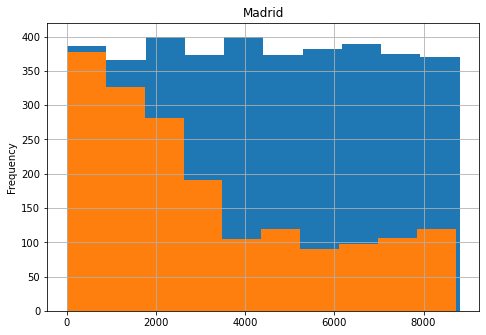

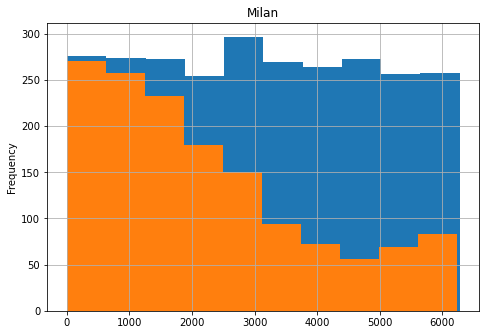

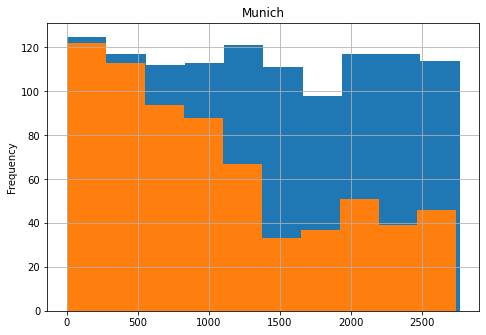

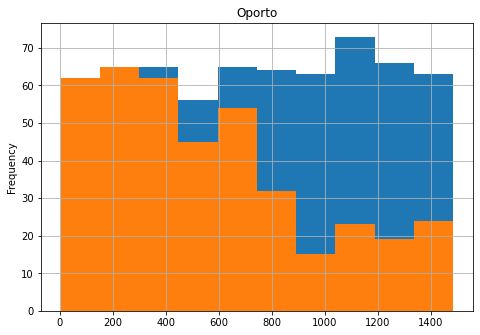

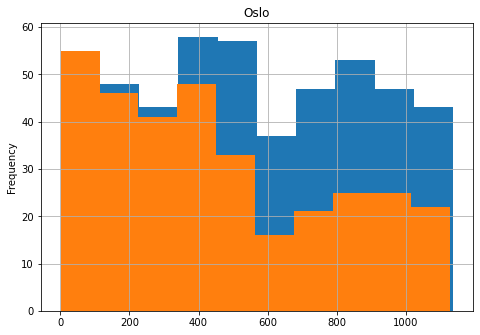

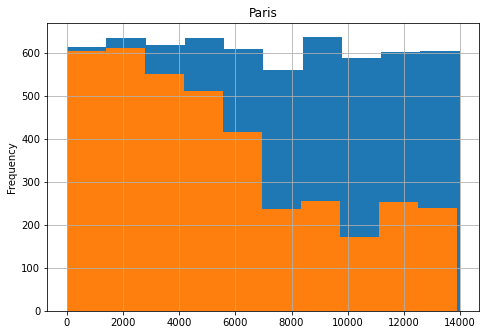

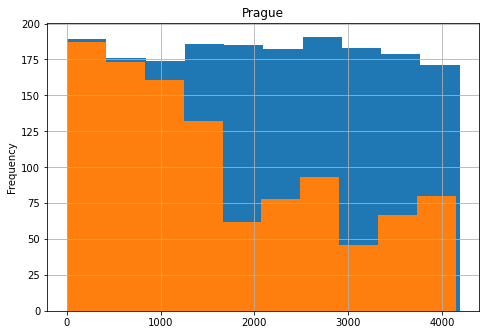

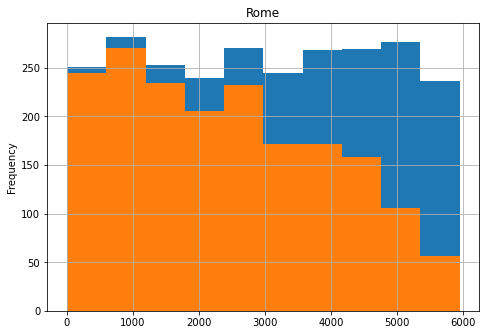

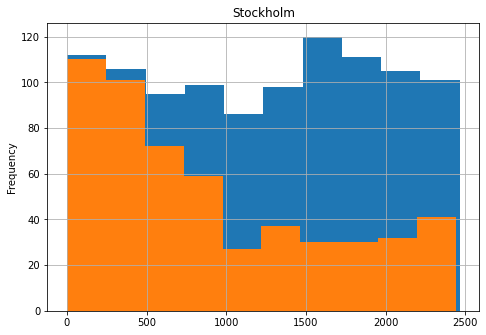

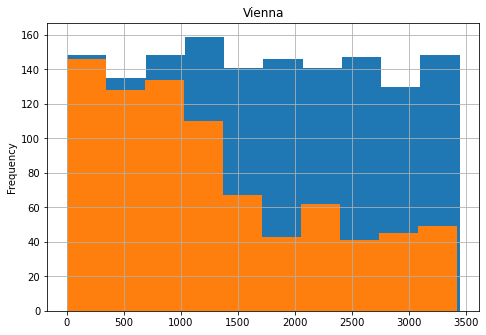

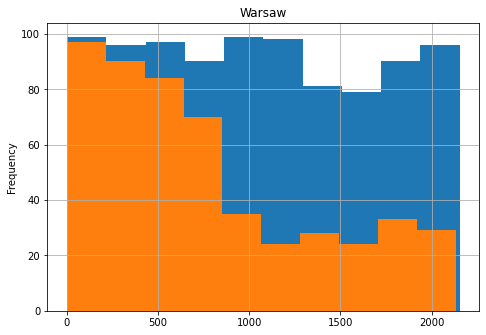

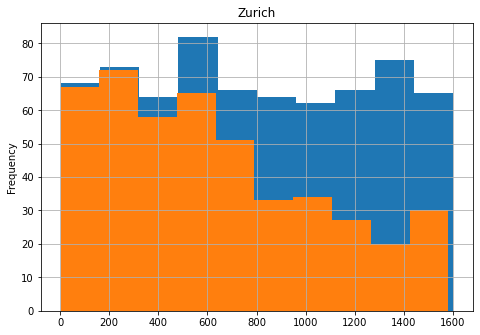

In [30]:
# посмотрим как распределился ранкинг
for i in city_list:
    fig, ax = plt.subplots()
    axes = fig.add_axes([0, 0, 1, 1])
    display(df[df['city']==i]['ranking'].plot(kind = 'hist', grid = True, title = i))

    display(df_no_null[df_no_null['city']==i]['ranking'].plot(kind = 'hist', grid = True, title = i))

видим, что пропуски распределены по ранжированию не равномерно для каждого города
в основном они имеют позицию ranking от 50% и выше
для заполнения пропусков будем основываться на этом распределении

/Users/evgeny/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


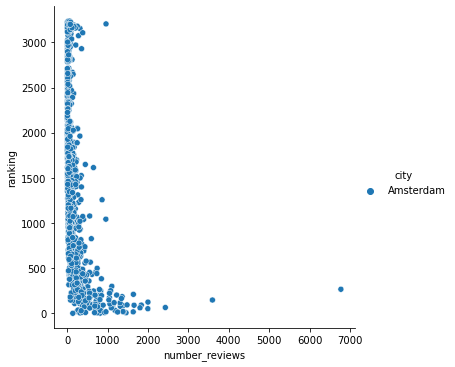

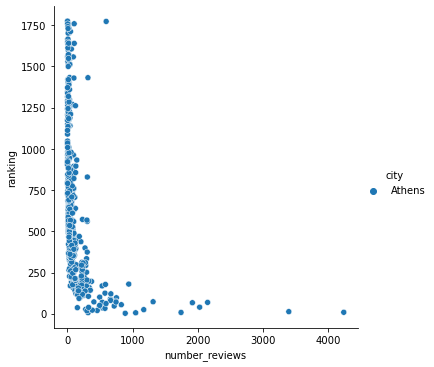

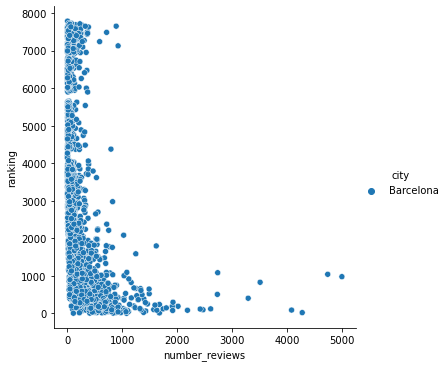

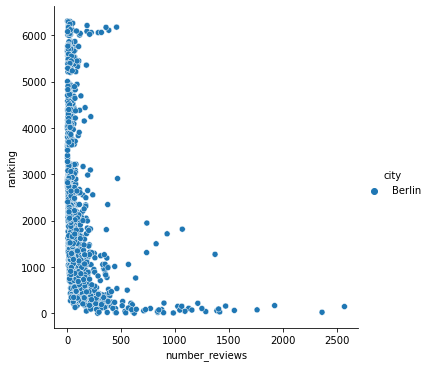

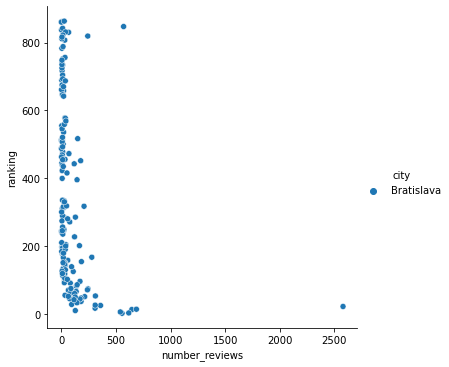

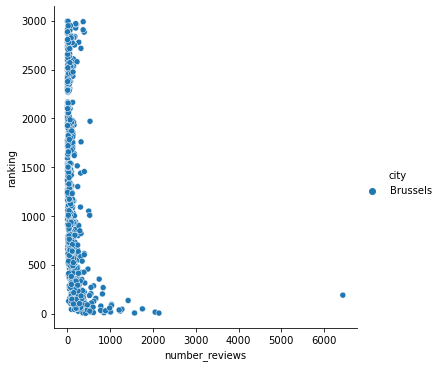

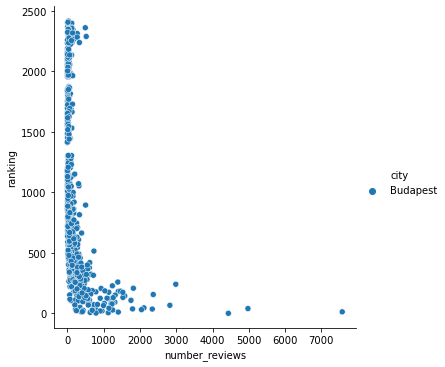

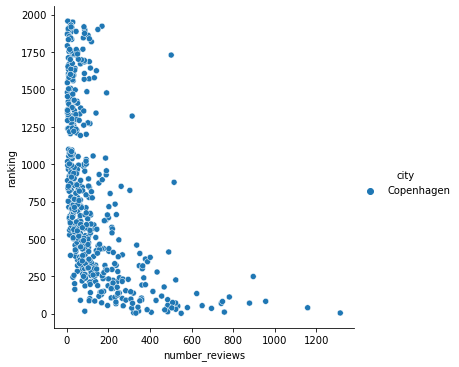

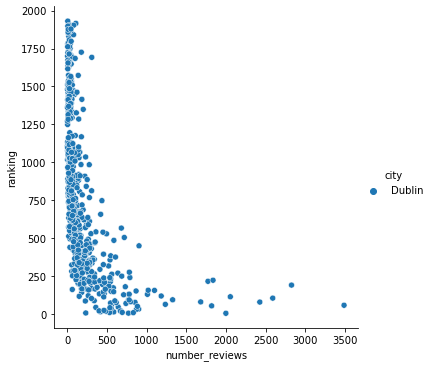

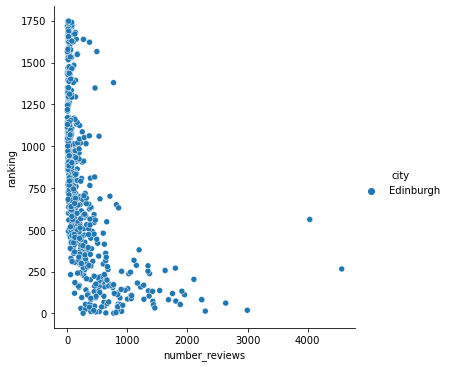

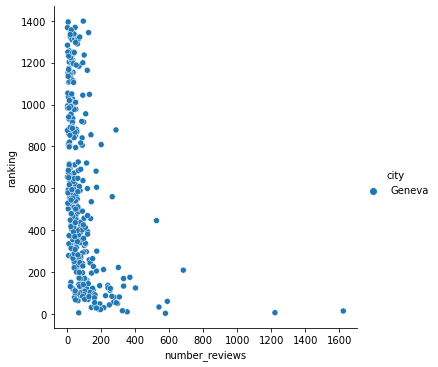

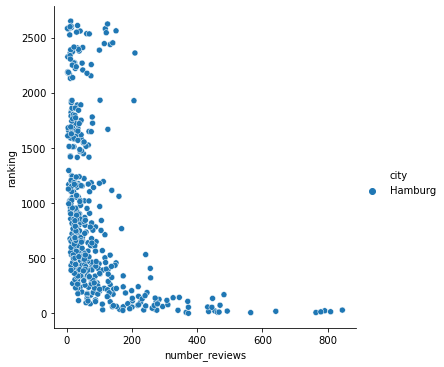

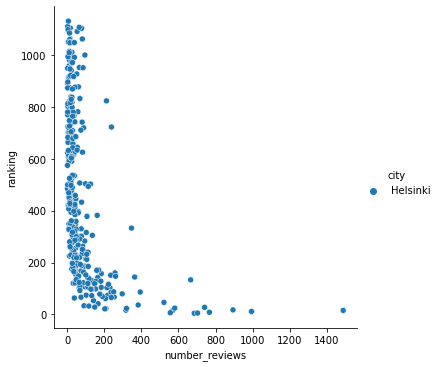

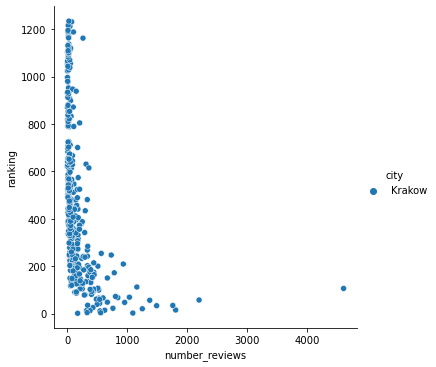

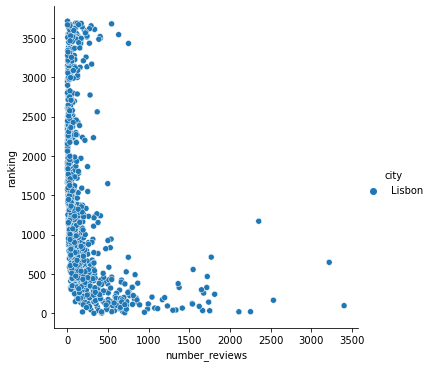

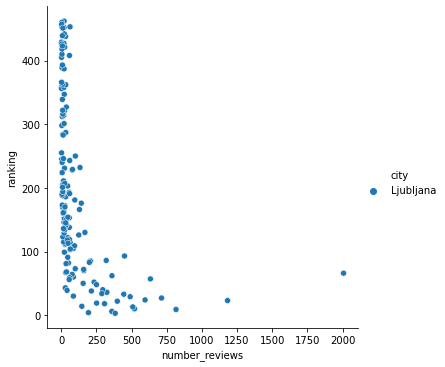

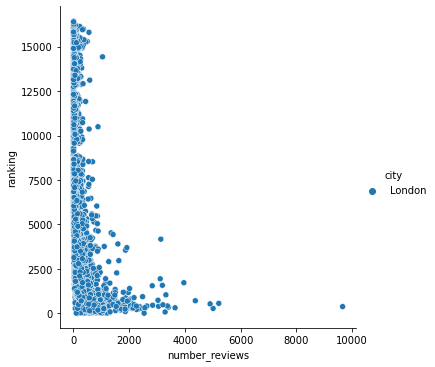

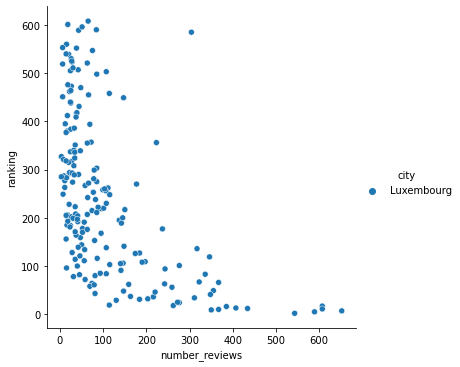

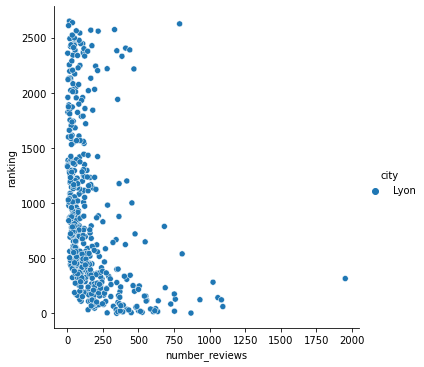

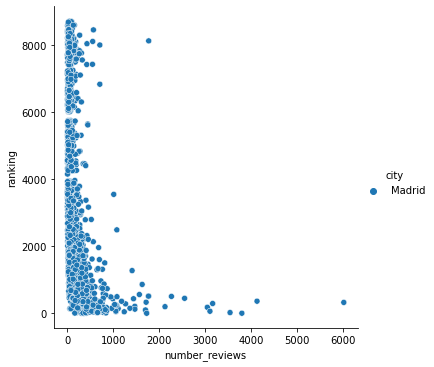

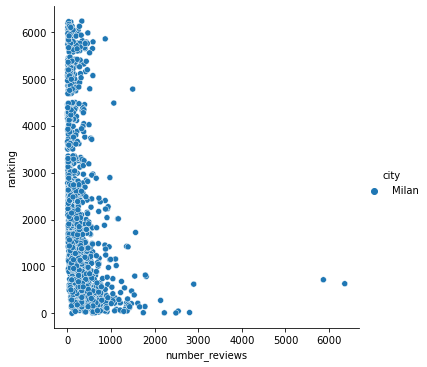

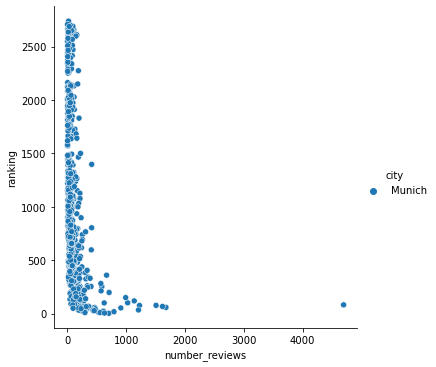

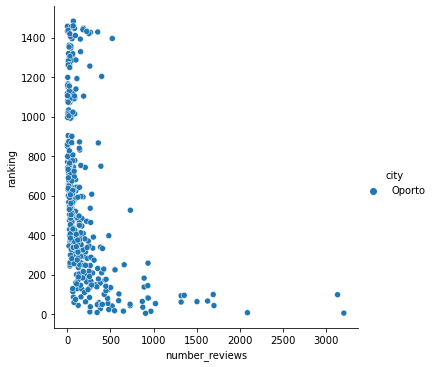

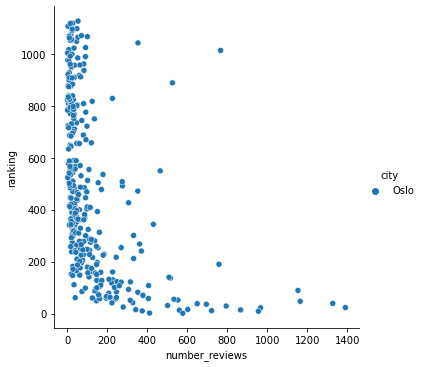

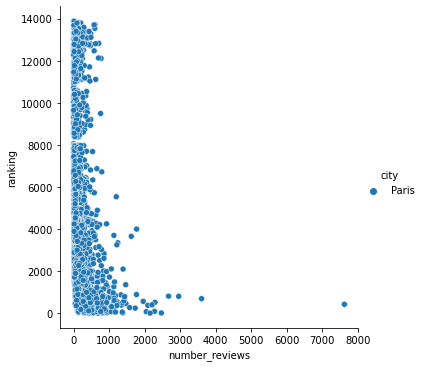

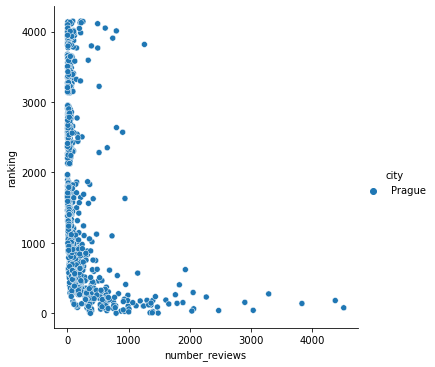

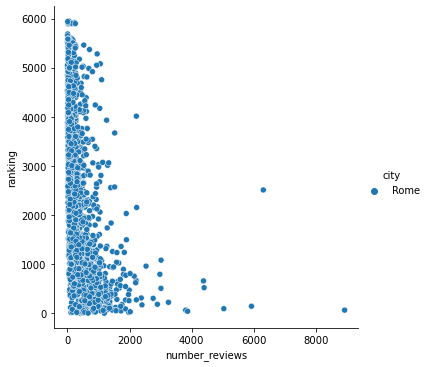

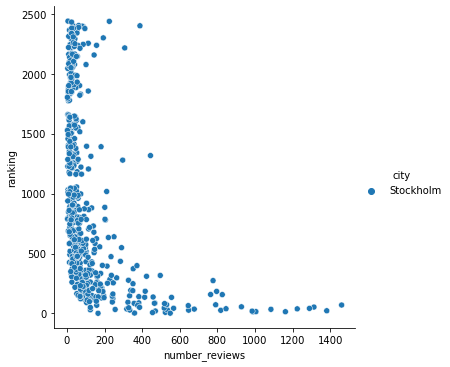

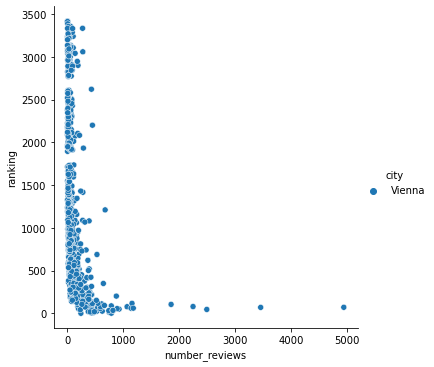

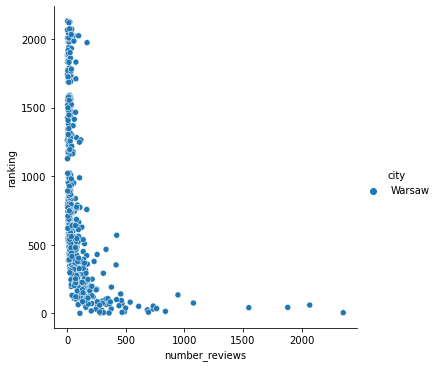

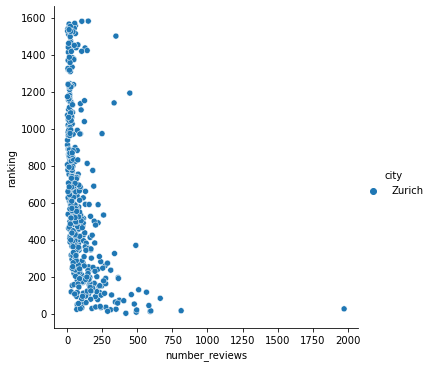

In [31]:
for i in city_list:
    display(sns.relplot(hue = 'city',x="number_reviews", y='ranking',
                        data=df_no_null[df_no_null['city'] == i]))

видим что рестораны с низким рангом по городу преимущественно имеют больше отзывов
логично, что рестораны вконце ранжирования могут не иметь отзывов

### number_reviews

In [32]:
# предположим что у ресторана нет отзывов, согласно tripadvisor такие рестораны так же не имеют рейтинга
# проверим так ли это
df[df['sample']==1]['rating'].min()



1.0

в целевой переменной мин показаель 1 и нет пропусков, если так, то все рестораны в выборке имеют отзывы,
либо rating не соответсвует действительности, но т.к. это целевой показатель будем ему доверять.
Следовательно все рестораны должный иметь отзывы


In [33]:
# заполним пропуски соседними значениями по городу в соответствии с ранжированием
# т.к. id ресторанов не уникальны, добавим колонку с индексами
df['unique_id'] = range(0,50000)
df_fill_test = df.copy()
add_new_f('unique_id')

In [34]:
df_fill_test = df_fill_test.sort_values(['ranking'], ascending=[True])[
    ['ranking', 'number_reviews', 'city','unique_id']]

In [35]:
fill_df = pd.DataFrame()
for i in city_list:
    df_reind = 'df_fill_' + i
    df_reind = df_fill_test.sort_values(
        ['ranking'], ascending=[True])[df_fill_test['city'] == i].reset_index().fillna(method='ffill')
    fill_df = pd.concat([fill_df, df_reind])


<ipython-input-35-49ac1aa8e57a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reind = df_fill_test.sort_values(


In [36]:
fill_df['number_reviews_new'] = fill_df['number_reviews']
fill_df = fill_df.reset_index()[['unique_id','number_reviews_new']]

In [37]:
df = df.merge(fill_df, left_on='unique_id', right_on='unique_id')

In [38]:
add_new_f('number_reviews_new')

### посмотрим на price_range

<AxesSubplot:>

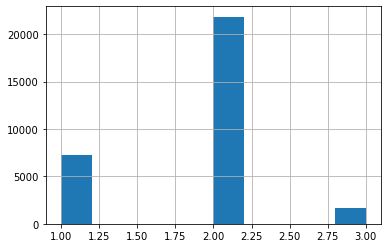

In [39]:
df_no_null.price_range.hist()

In [40]:
# возможно цена зависит от кол ва представленных кухонь
# создадим столбец с кол-вом кухонь в ресторане count_cs
df['count_cs'] = df['cuisine_style_new'].apply(lambda x: len(x) if type(x)!= float else x)
add_new_f('count_cs')

In [41]:
df_no_null = df.copy()
df_no_null = df_no_null.dropna()

/Users/evgeny/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


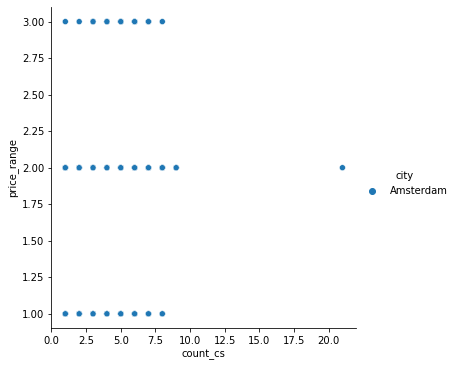

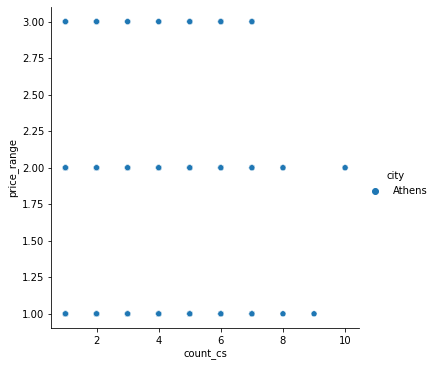

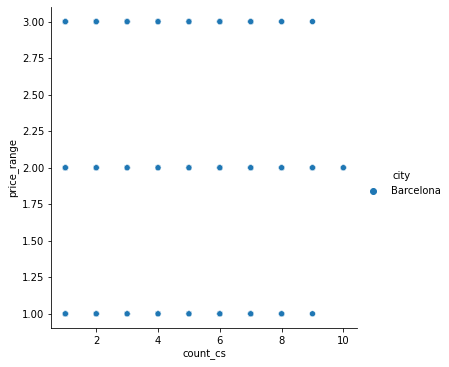

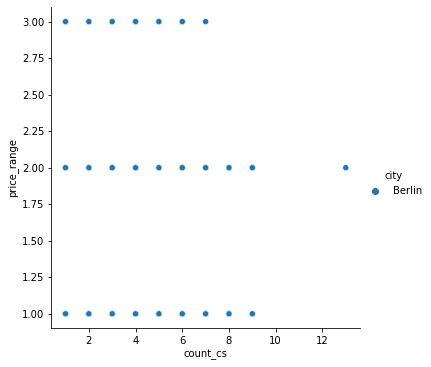

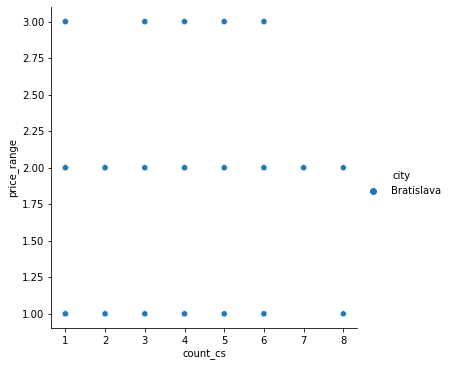

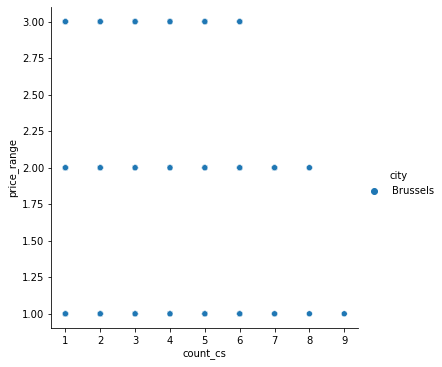

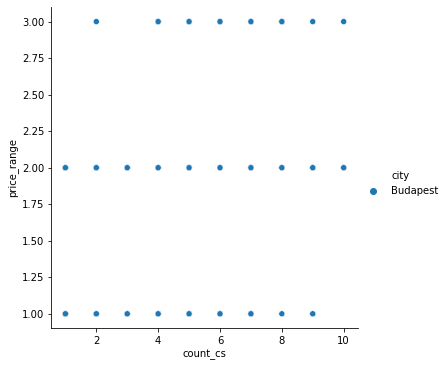

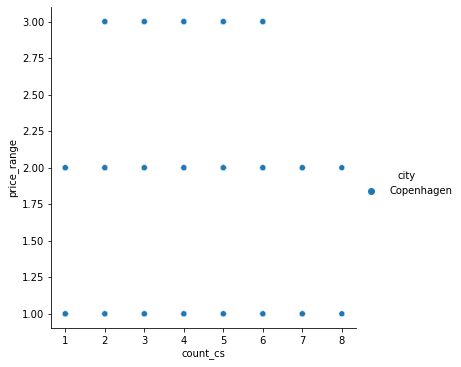

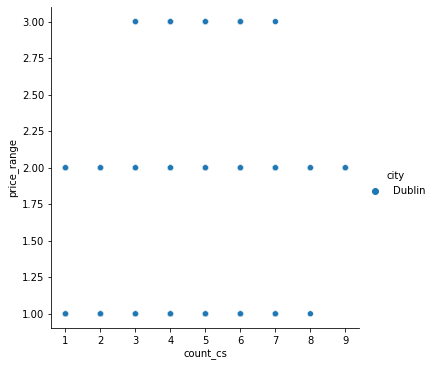

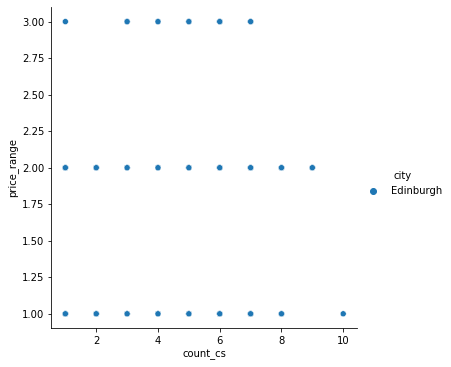

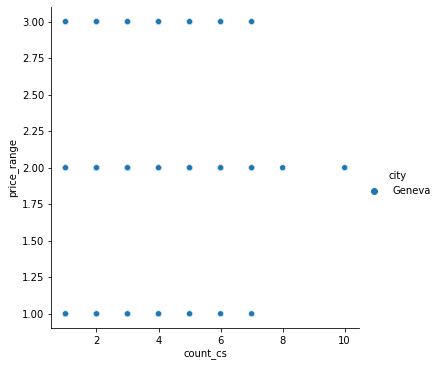

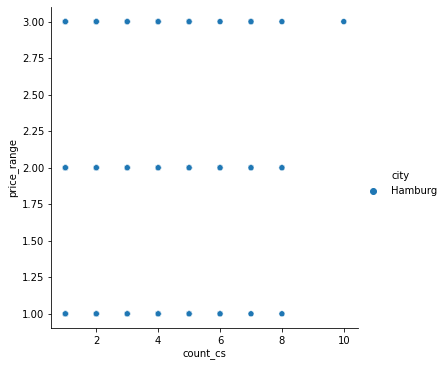

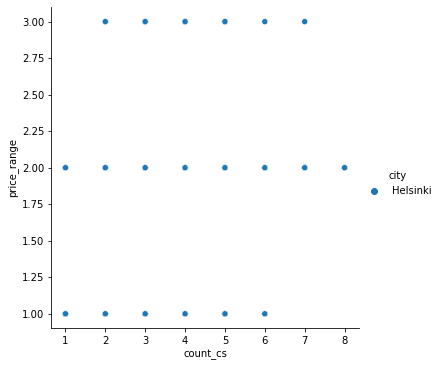

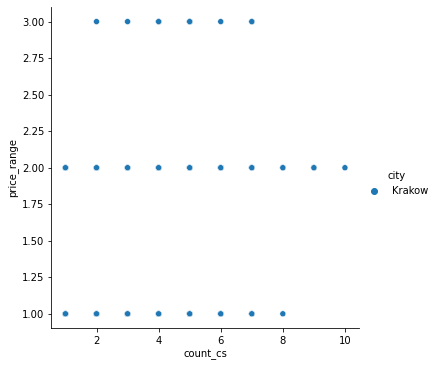

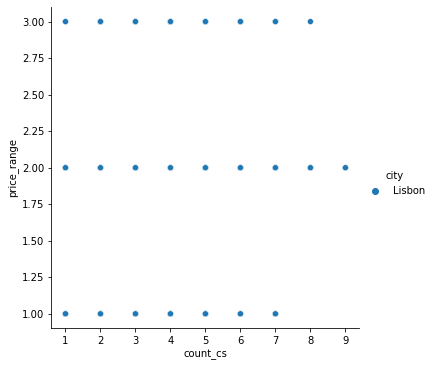

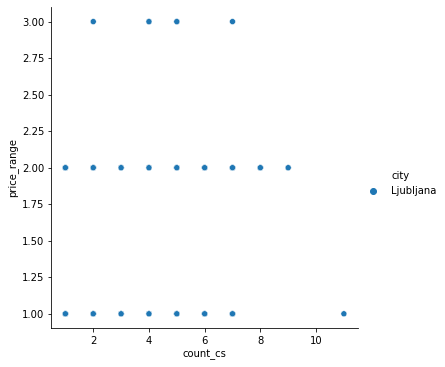

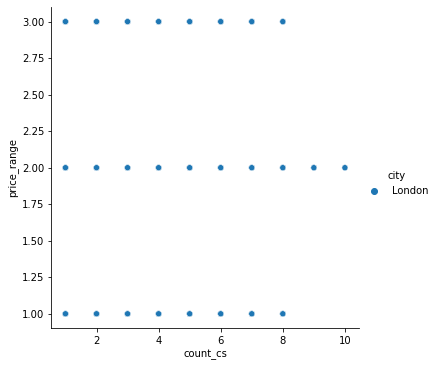

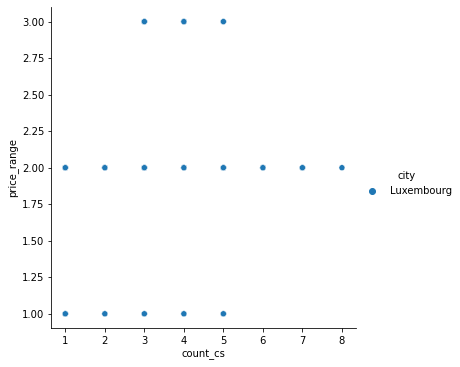

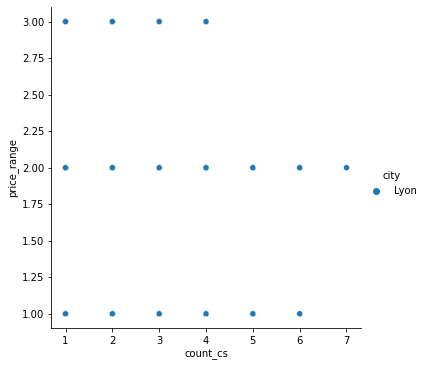

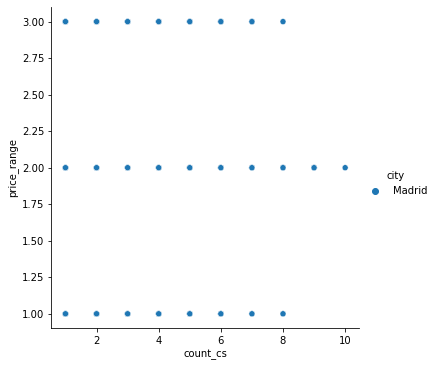

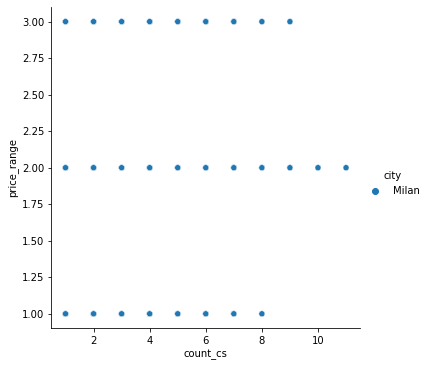

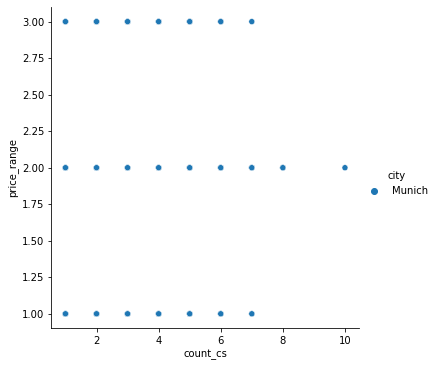

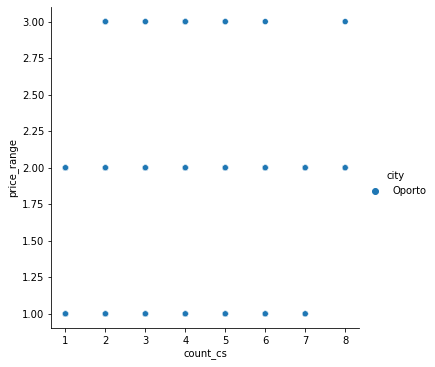

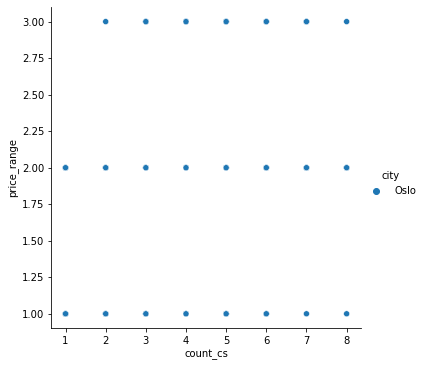

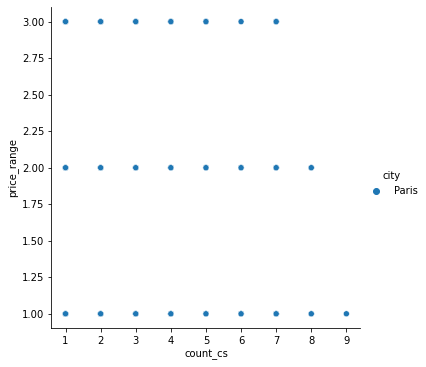

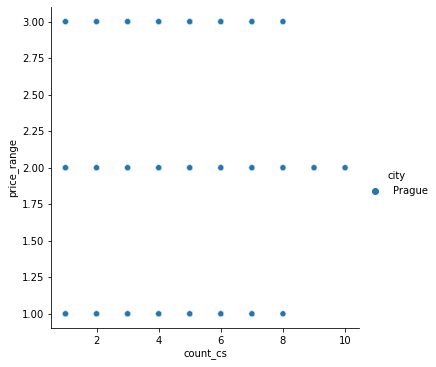

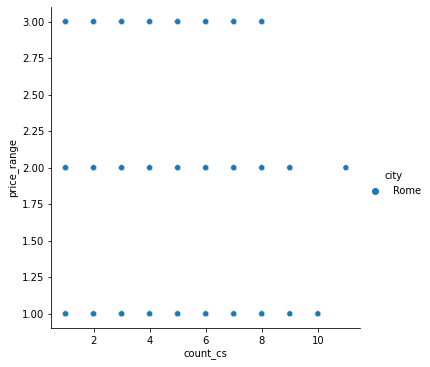

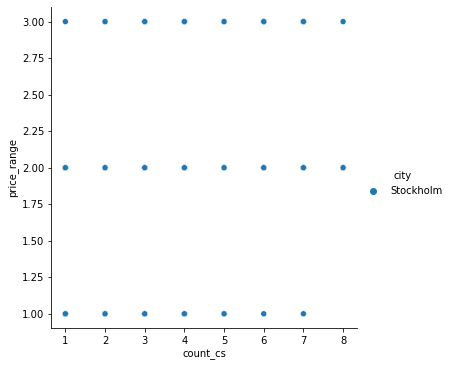

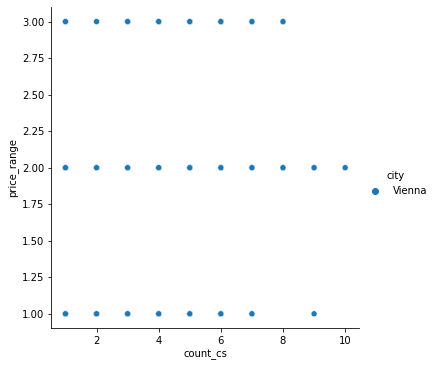

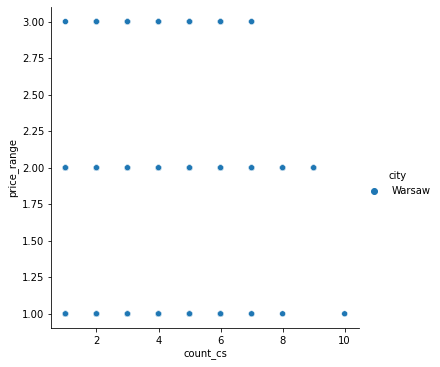

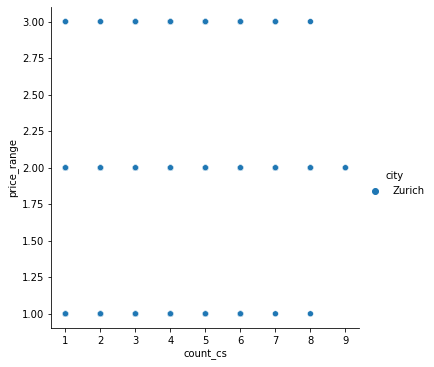

In [42]:
for i in city_list:
    display(sns.relplot(hue = 'city',x="count_cs", y='price_range',
                        data=df_no_null[df_no_null['city'] == i]))

по отношению к кол ву кухонь распределение практически равномерное

In [43]:
# посмотрим по отзывам
df_no_null.groupby('price_range').number_reviews_new.sum()

price_range
1.0     701182.0
2.0    4244510.0
3.0     650926.0
Name: number_reviews_new, dtype: float64

<AxesSubplot:title={'center':'Amsterdam'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Amsterdam'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Athens'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Athens'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Barcelona'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Barcelona'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Berlin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Berlin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Bratislava'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Bratislava'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Brussels'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Brussels'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Budapest'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Budapest'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Copenhagen'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Copenhagen'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Dublin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Dublin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Edinburgh'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Edinburgh'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Geneva'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Geneva'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Hamburg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Hamburg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Helsinki'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Helsinki'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Krakow'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Krakow'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lisbon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lisbon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Ljubljana'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Ljubljana'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'London'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'London'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Luxembourg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Luxembourg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lyon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lyon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Madrid'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Madrid'}, ylabel='Frequency'>

<ipython-input-44-58191d95876a>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<AxesSubplot:title={'center':'Milan'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Milan'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Munich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Munich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oporto'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oporto'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oslo'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oslo'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Paris'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Paris'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Prague'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Prague'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Rome'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Rome'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Stockholm'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Stockholm'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Vienna'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Vienna'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Warsaw'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Warsaw'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Zurich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Zurich'}, ylabel='Frequency'>

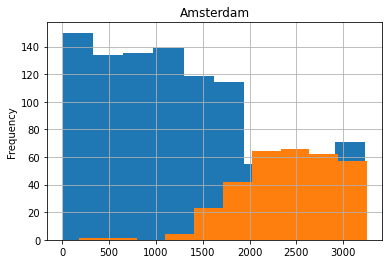

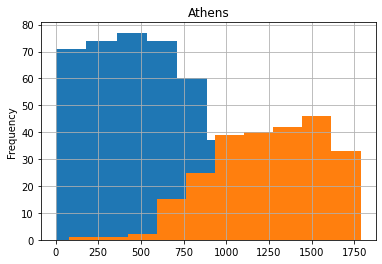

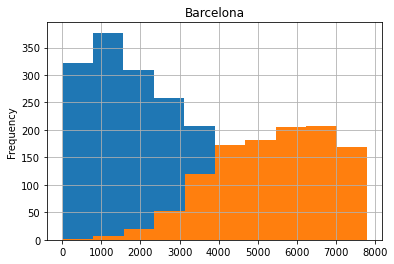

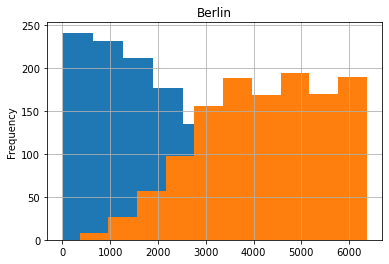

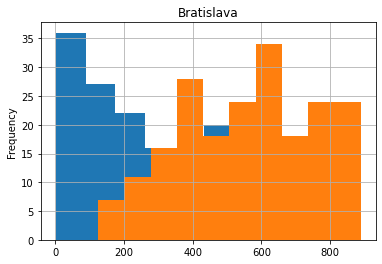

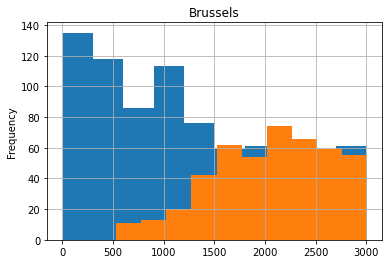

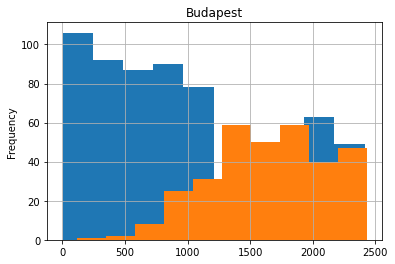

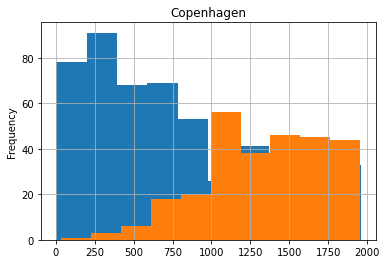

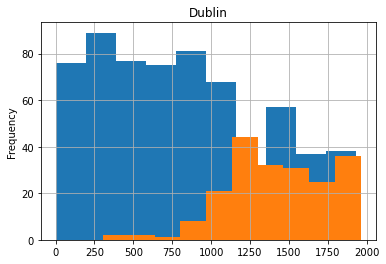

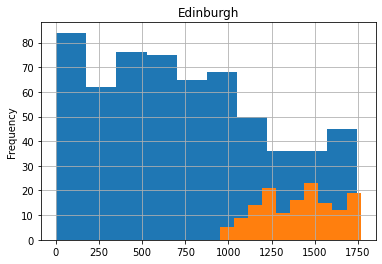

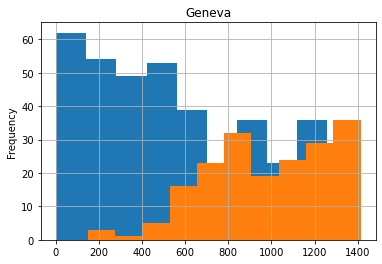

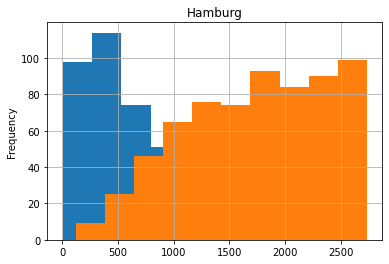

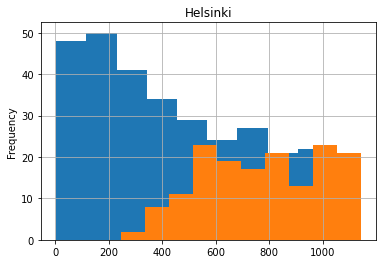

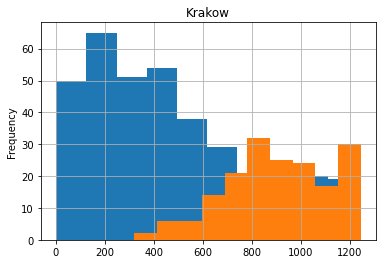

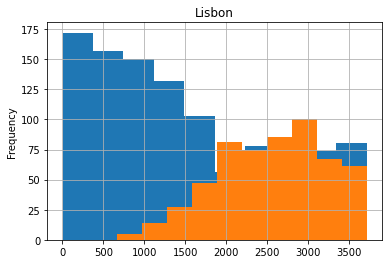

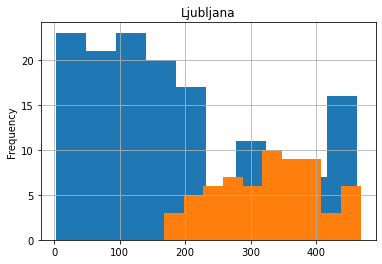

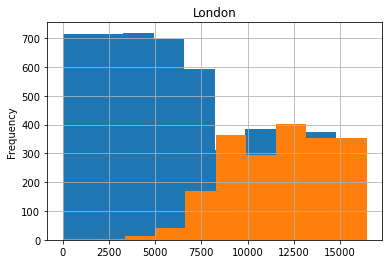

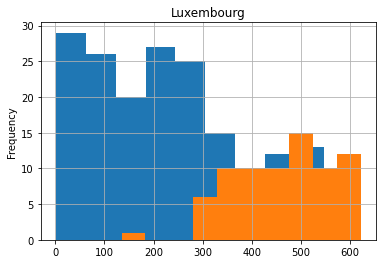

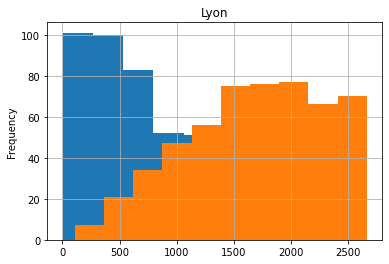

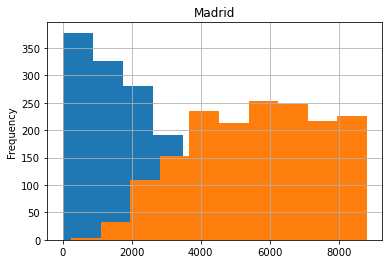

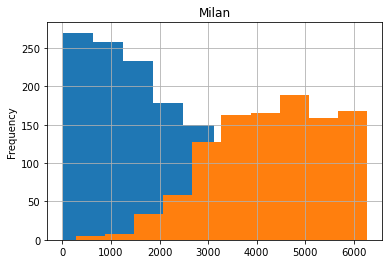

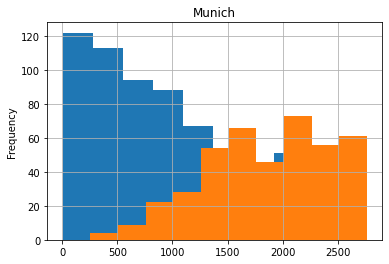

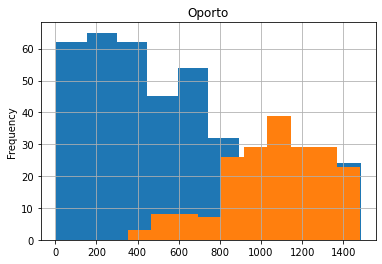

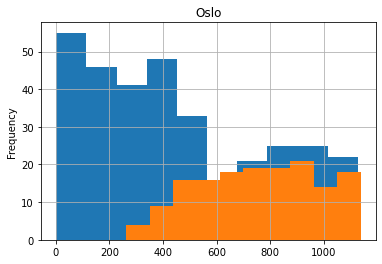

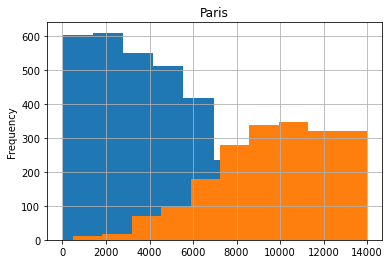

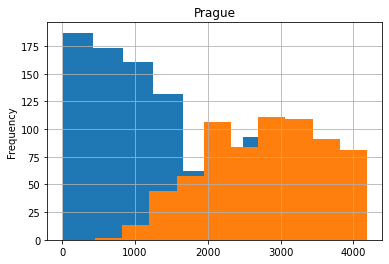

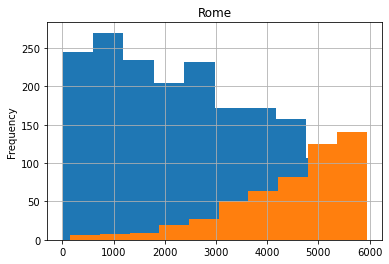

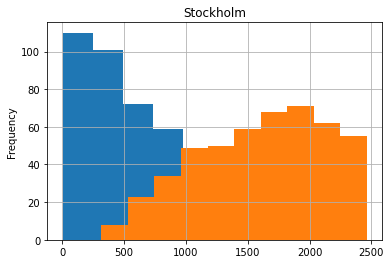

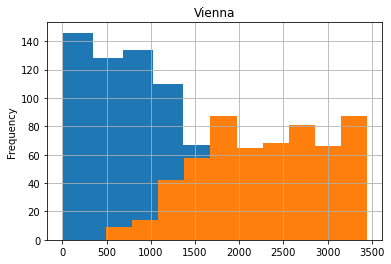

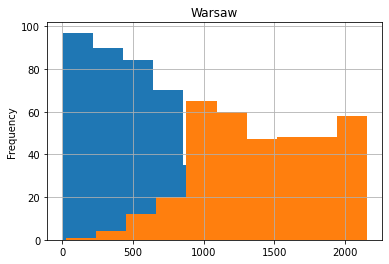

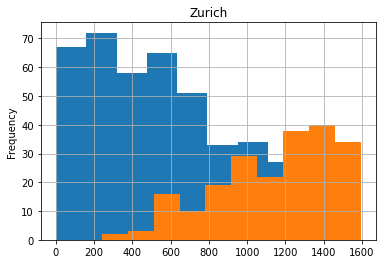

In [44]:
# посмотрим на ранг ресторанов с пропусками по цене
for i in city_list:
    fig, ax = plt.subplots()
    display(df_no_null[df_no_null['city']==i]['ranking'].plot(kind = 'hist', grid = True, title = i))
    display(df[(df['city']==i)&(df['price_range'].isnull())]['ranking'].plot(kind = 'hist', grid = True, title = i))
    

In [45]:
df_no_null.corr()

ranking  price_range  number_reviews    sample    rating  \
ranking             1.000000    -0.114637       -0.216773  0.008712 -0.103947   
price_range        -0.114637     1.000000        0.178102 -0.005322 -0.010125   
number_reviews     -0.216773     0.178102        1.000000  0.003442  0.010835   
sample              0.008712    -0.005322        0.003442  1.000000  0.957451   
rating             -0.103947    -0.010125        0.010835  0.957451  1.000000   
id                  0.799526    -0.088694       -0.177204 -0.244498 -0.345783   
real_data                NaN          NaN             NaN       NaN       NaN   
unique_id           0.004450     0.001509       -0.002764  0.690734  0.661567   
number_reviews_new -0.216773     0.178102        1.000000  0.003442  0.010835   
count_cs           -0.310745     0.163601        0.328436 -0.005566  0.039138   

                          id  real_data  unique_id  number_reviews_new  \
ranking             0.799526        NaN   0.004450           -0.216773   
price_range        -0.088694        NaN   0.001509            0.178102   
number_reviews     -0.177204        NaN  -0.002764            1.000000   
sample             -0.244498        NaN   0.690734            0.003442   
rating             -0.345783        NaN   0.661567            0.010835   
id                  1.000000        NaN  -0.136734           -0.177204   
real_data                NaN        NaN        NaN                 NaN   
unique_id          -0.136734        NaN   1.000000           -0.002764   
number_reviews_new -0.177204        NaN  -0.002764            1.000000   
count_cs           -0.241884        NaN  -0.005353            0.328436   

                    count_cs  
ranking            -0.310745  
price_range         0.163601  
number_reviews      0.328436  
sample             -0.005566  
rating              0.039138  
id                 -0.241884  
real_data                NaN  
unique_id          -0.005353  
number_reviews_new  0.328436  
count_cs            1.000000

Видим, что пропусков по price_range в некоторых городах больше 50%.
Основываться при заполнении пропусков практически не на что, только создадим лишний шум.
Признак price_range учитывать в модели не будем


### Посмотрим на reviews

Раннее мы выделили только отзывы в reviews_new и заполнили пропуски значением 'Unknown'
В условии reviews это последнии два отзыва, посмотрим на их распределение

In [46]:
# модифицироем в лист
df['reviews_new_list'] = df['reviews_new'].apply(lambda x: x.split("', '") if x != 'Unknown' else x)

In [47]:
df['reviews_new_list'] = df['reviews_new_list'].apply(lambda x: len(x) if type(x)== list else x)
add_new_f('reviews_new_list')

In [48]:
df['reviews_new_list'].value_counts()

2          34787
Unknown     8114
1           7099
Name: reviews_new_list, dtype: int64

видим что не у всех ресторанов по два отзыва,
посмотрим ближе

<AxesSubplot:title={'center':'Amsterdam'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Amsterdam'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Athens'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Athens'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Barcelona'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Barcelona'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Berlin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Berlin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Bratislava'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Bratislava'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Brussels'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Brussels'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Budapest'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Budapest'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Copenhagen'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Copenhagen'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Dublin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Dublin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Edinburgh'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Edinburgh'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Geneva'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Geneva'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Hamburg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Hamburg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Helsinki'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Helsinki'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Krakow'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Krakow'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lisbon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lisbon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Ljubljana'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Ljubljana'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'London'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'London'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Luxembourg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Luxembourg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lyon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lyon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Madrid'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Madrid'}, ylabel='Frequency'>

<ipython-input-49-901d61286e16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<AxesSubplot:title={'center':'Milan'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Milan'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Munich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Munich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oporto'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oporto'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oslo'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oslo'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Paris'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Paris'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Prague'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Prague'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Rome'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Rome'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Stockholm'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Stockholm'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Vienna'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Vienna'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Warsaw'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Warsaw'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Zurich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Zurich'}, ylabel='Frequency'>

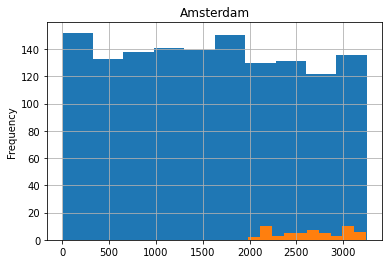

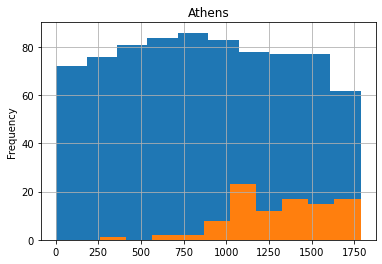

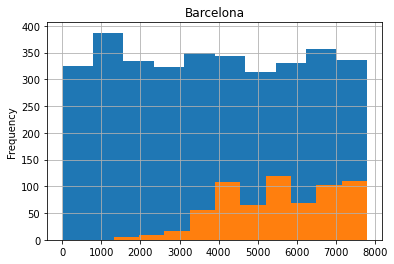

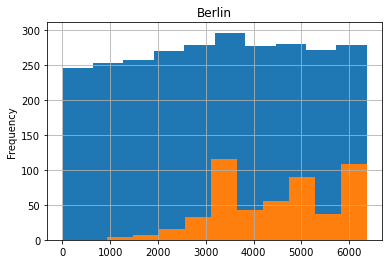

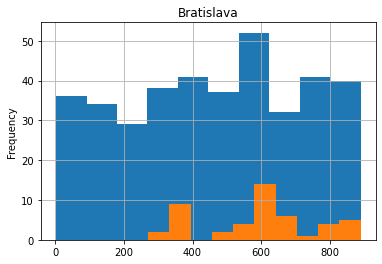

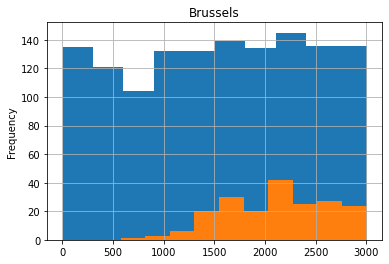

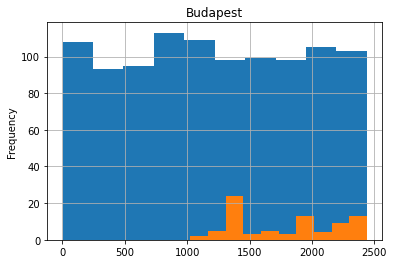

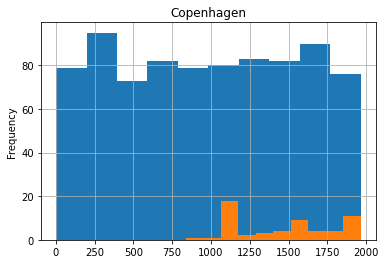

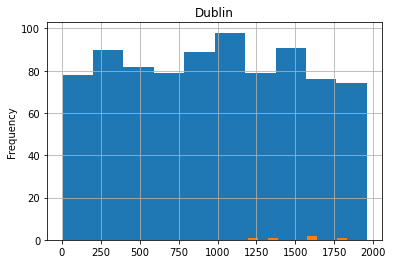

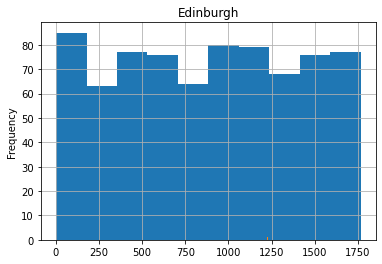

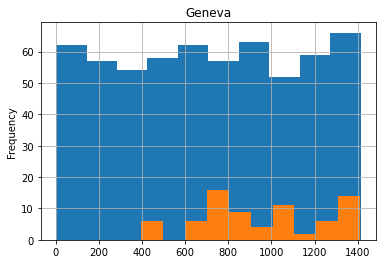

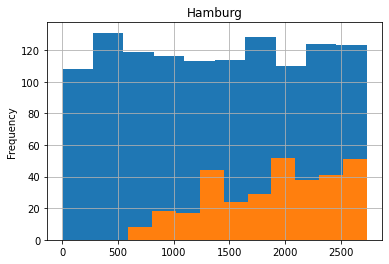

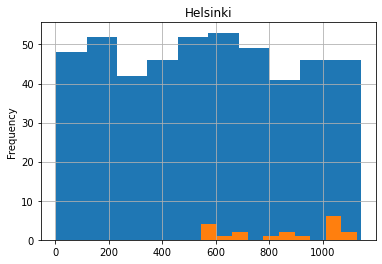

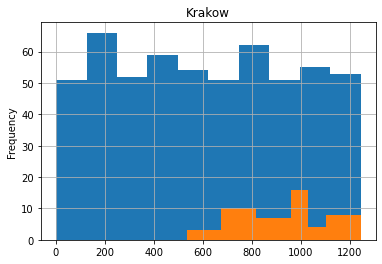

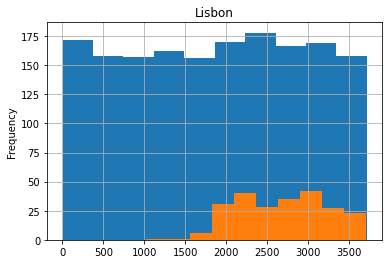

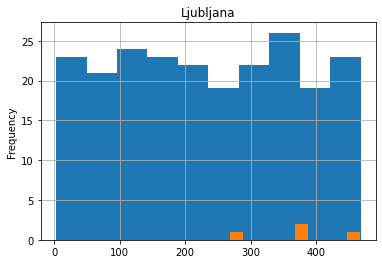

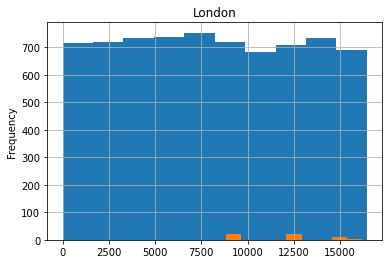

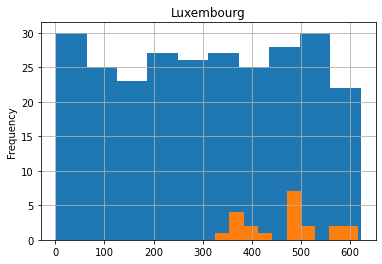

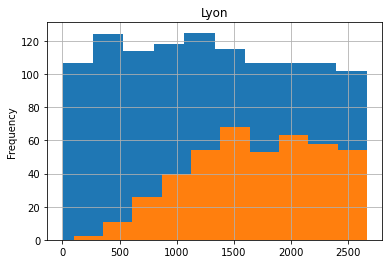

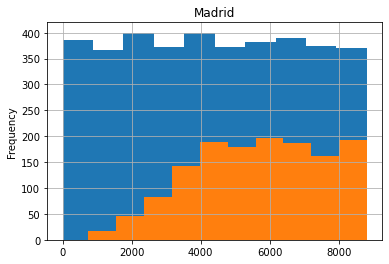

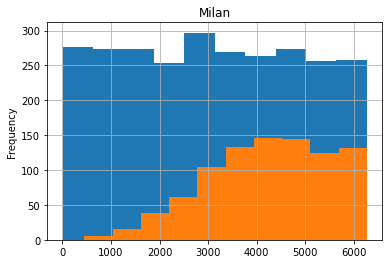

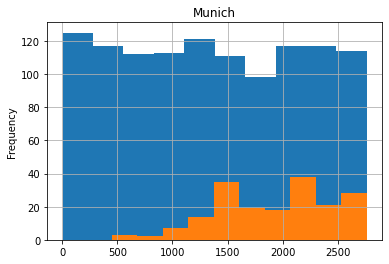

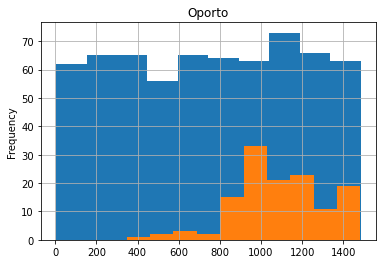

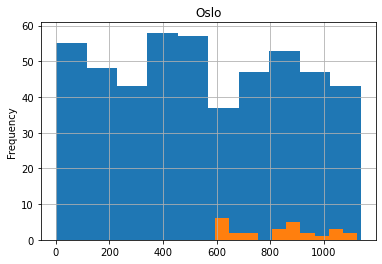

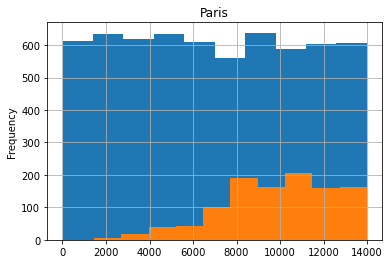

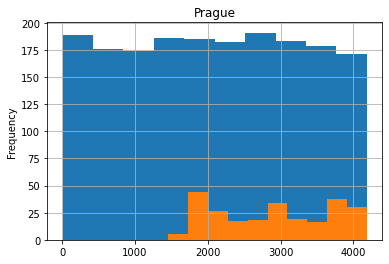

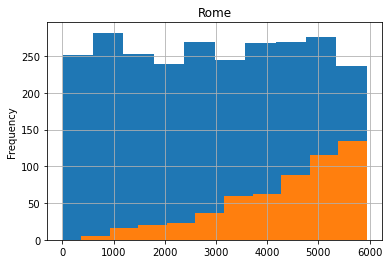

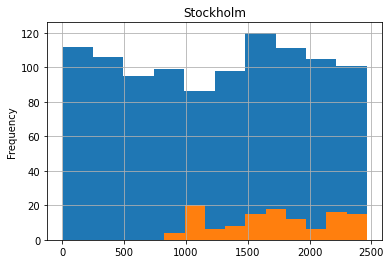

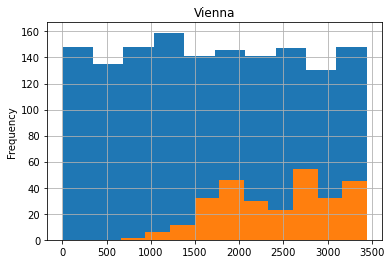

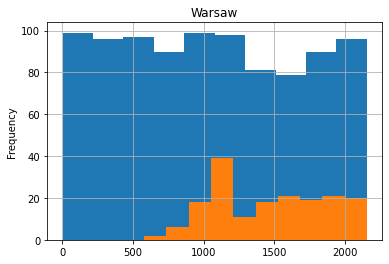

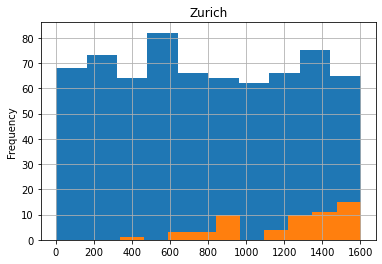

In [49]:
# Посмотрим на ранг ресторанов в городе с Unknown
for i in city_list:
    fig, ax = plt.subplots()
    display(df[df['city'] == i]['ranking'].plot(
        kind='hist', grid=True, title=i))
    display(df[(df['city'] == i) & (df['reviews_new_list'] == 'Unknown')]
            ['ranking'].plot(kind='hist', grid=True, title=i))

в основном пропуски у ресторанов в конце ранкинга за исключением некоторых городов, например Мадрид, Милан, Париж

<AxesSubplot:>

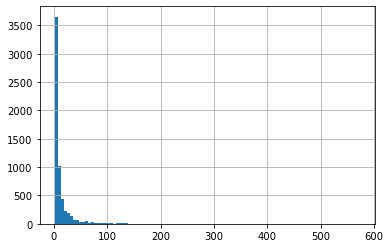

In [50]:
df[(df['reviews_new_list']=='Unknown')]['number_reviews'].hist(bins=100)

В основном пропуски у ресторанов с минимальным кол вом отзывов

In [51]:
# посмотрим на рестораны с мин кол вом отзывов
df_no_null = df.copy()
df_no_null = df_no_null.dropna()
df_no_null.query('number_reviews ==2')['reviews_new_list'].value_counts()

1    115
2     90
Name: reviews_new_list, dtype: int64

видим, что у ресторанов с 2 отзывами может иметь всего один написанный

<AxesSubplot:title={'center':'два отзыва'}, xlabel='number_reviews', ylabel='reviews_new_list'>

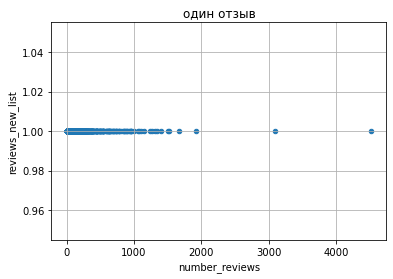

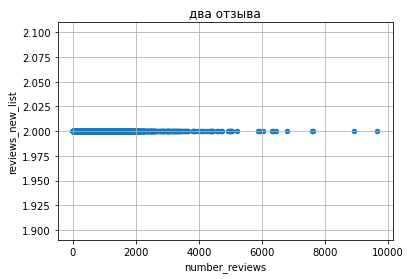

In [52]:
# посмотрим на распределение написанных отзывов
df_no_null[df_no_null['reviews_new_list']==1].plot(x = 'number_reviews', 
        y = 'reviews_new_list', 
        kind = 'scatter', 
        grid = True, 
        title = 'один отзыв')
df_no_null[df_no_null['reviews_new_list']==2].plot(x = 'number_reviews', 
        y = 'reviews_new_list', 
        kind = 'scatter', 
        grid = True, 
        title = 'два отзыва'                                           
        )

видим, что даже у ресторанов с более 1000 отзывов написанным может быть всего один, что выглядит достаточно странным

In [53]:
# расчитаем границы при которых ко во отзывов при 1 написанном будет считаться выбросом
# IQR
df_iqr = df_no_null[df_no_null['reviews_new_list'] == 1]

IQR = df_iqr.number_reviews.quantile(
    0.75) - df_iqr.number_reviews.quantile(0.25)
perc25 = df_iqr.number_reviews.quantile(0.25)
perc75 = df_iqr.number_reviews.quantile(0.75)
print('25th percentile: {},'.format(perc25), '75th percentile: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Пределы: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

# Стандартное отклонение
s = np.std(df_iqr.number_reviews, ddof=1)
m = df_iqr.number_reviews.mean()
right_b = m + 3*s
print('Граница правого предела: ', round(right_b))

25th percentile: 10.0, 75th percentile: 69.0, IQR: 59.0,  Пределы: [-78.5, 157.5].
Граница правого предела:  617


предел полученный с помощью IQR выглядит правдоподобным, используем его

In [54]:
df.loc[df['number_reviews_new']>157.2,'reviews_new_list'] = 2

<AxesSubplot:>

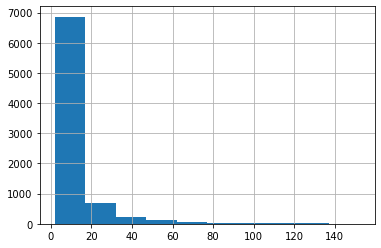

In [55]:
df[df['reviews_new_list']=='Unknown']['number_reviews_new'].hist()

/Users/evgeny/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


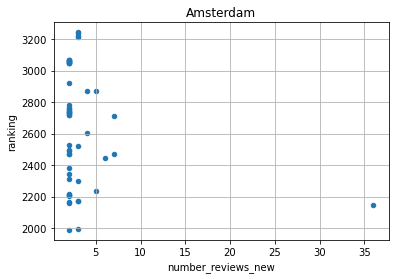

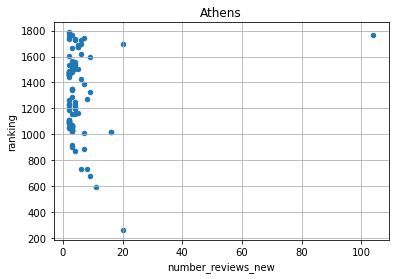

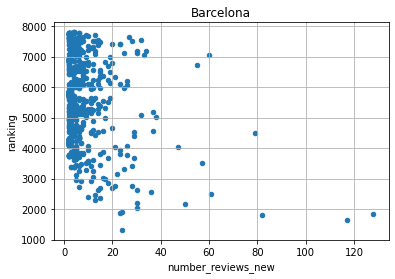

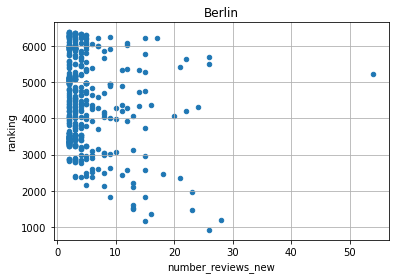

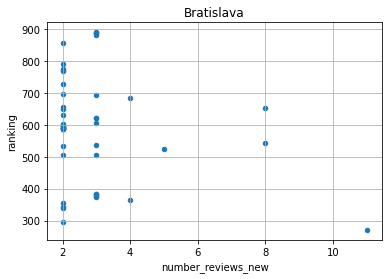

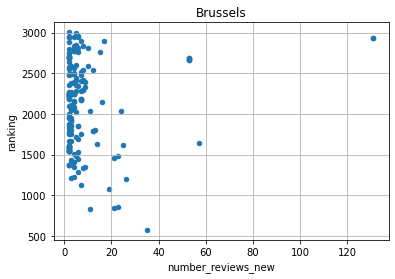

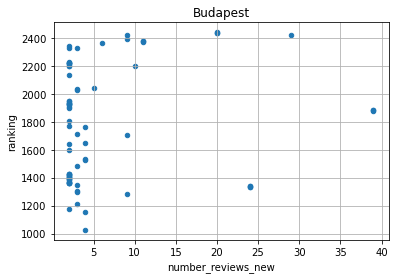

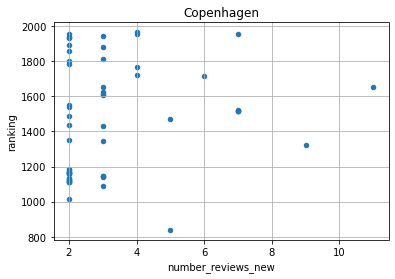

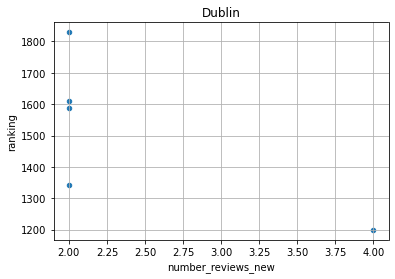

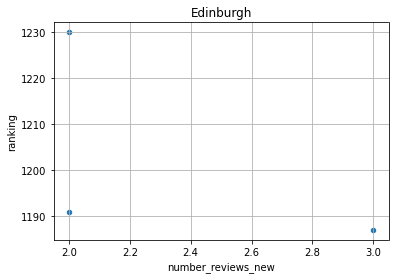

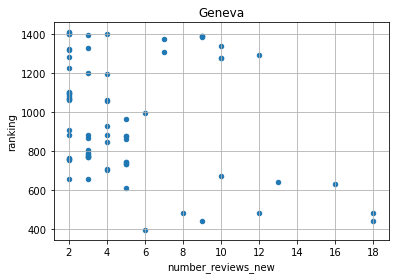

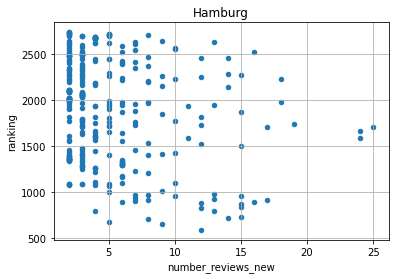

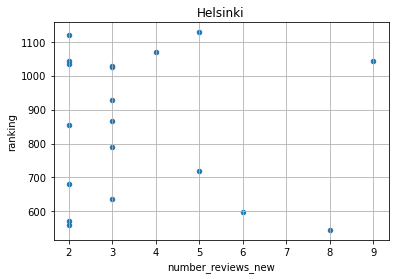

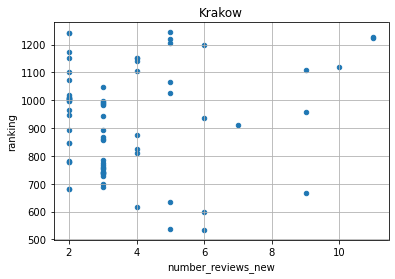

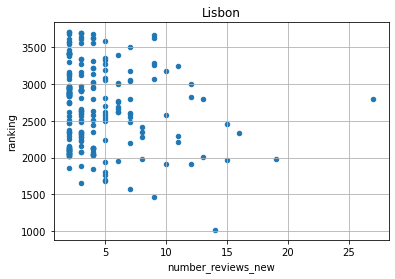

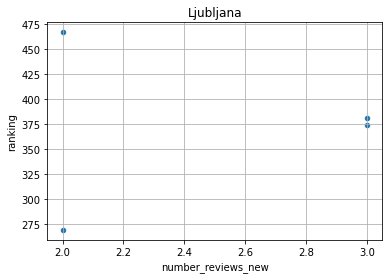

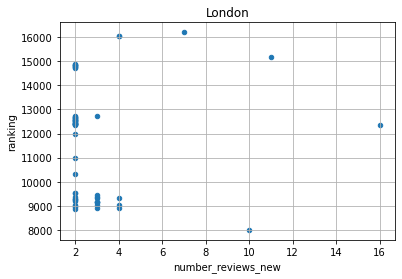

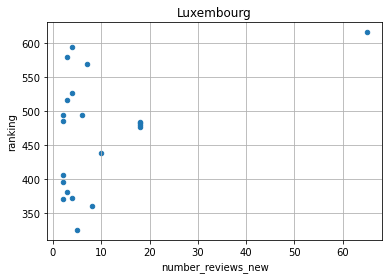

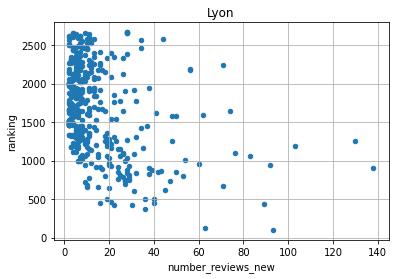

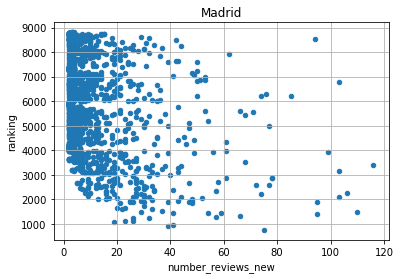

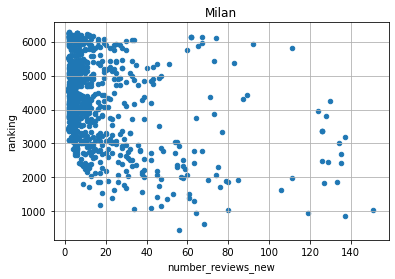

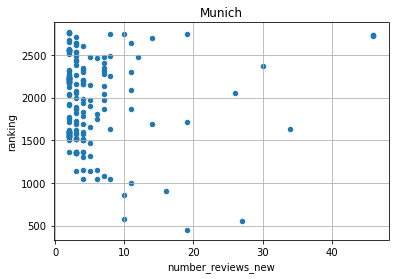

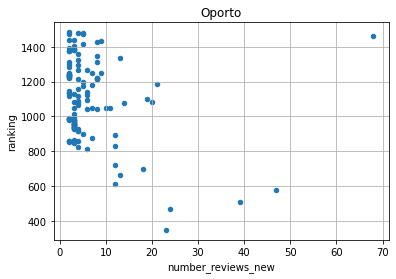

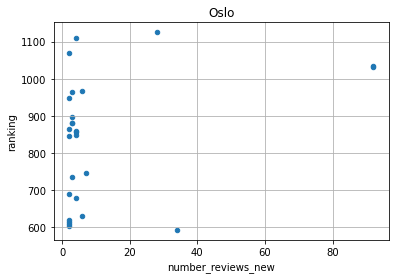

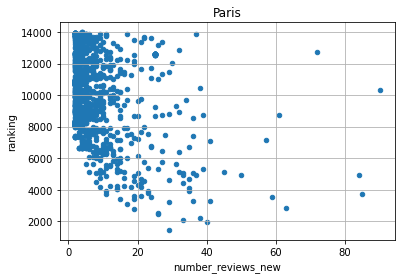

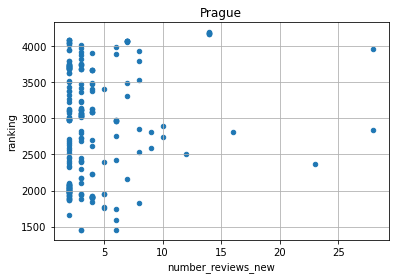

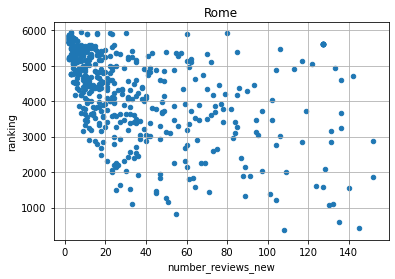

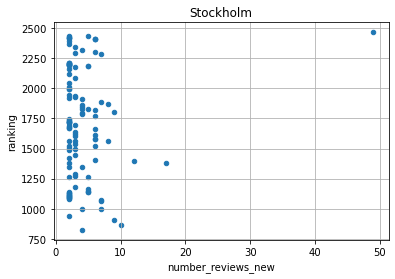

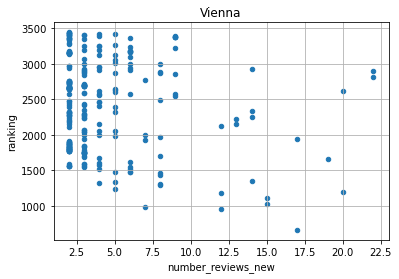

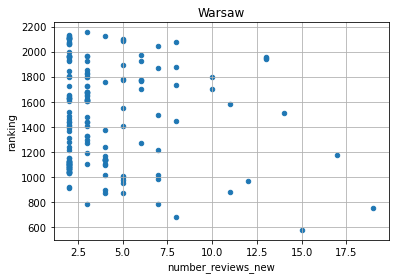

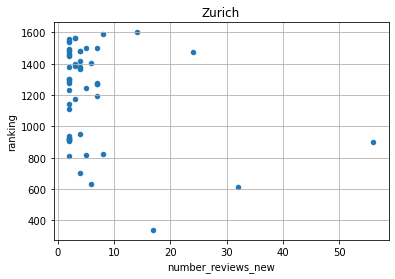

In [56]:
# посмотрим на оставшиеся Unknown
for i in city_list:
    df[(df['reviews_new_list'] == 'Unknown') & (df['city'] == i)].plot(x='number_reviews_new',
                                                                       y='ranking',
                                                                       kind='scatter',
                                                                       grid=True,
                                                                       title=i
                                                                       )

In [57]:
# заполним Unknown случайными значениями
df.loc[(df['reviews_new_list'] == 'Unknown'), 'reviews_new_list'] = df.loc[(
    df['reviews_new_list'] == 'Unknown'), 'reviews_new_list'].apply(lambda x: np.random.choice([0, 1, 2]))
df['reviews_new_list'] = df['reviews_new_list'].apply(lambda x: int(x))

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   restaurant_id       50000 non-null  object 
 1   city                50000 non-null  object 
 2   cuisine_style       38410 non-null  object 
 3   ranking             50000 non-null  float64
 4   price_range         32639 non-null  float64
 5   number_reviews      46800 non-null  float64
 6   reviews             49998 non-null  object 
 7   url_ta              50000 non-null  object 
 8   id_ta               50000 non-null  object 
 9   sample              50000 non-null  int64  
 10  rating              50000 non-null  float64
 11  cuisine_style_new   38410 non-null  object 
 12  reviews_new         50000 non-null  object 
 13  date_reviews        41886 non-null  object 
 14  id                  50000 non-null  int64  
 15  real_data           50000 non-null  float64
 16  uniq

In [59]:
# посчитаем кол-во букв в отзыве и создадим новуый столбец df.len_reviews, где 0 == Unknown
pattern = re.compile('\w')
df['len_reviews'] = df['reviews_new'].apply(lambda x: len(
    pattern.findall(x)) if type(x) == str and x != 'Unknown' else 0 if x == 'Unknown' else x )
add_new_f('len_reviews')

In [60]:
 df.query('len_reviews >0')['len_reviews'].min()
df.query('0 < len_reviews < 4 ')
# встречаются мусорные отзывы вроде SW4,Ms, Mrs, Mr, vfm

restaurant_id        city  \
2366        id_2366   Barcelona   
5158        id_5158       Paris   
5544        id_5544      Athens   
7767        id_7767       Milan   
7950        id_7950      London   
8771        id_8771      Prague   
8941        id_8941  Copenhagen   
11135       id_7486       Paris   
11499       id_1757      Lisbon   
11770       id_1447       Milan   
11985       id_8956      London   
13079       id_2132       Milan   
13597       id_3064      Madrid   
14312       id_1126      Munich   
14485      id_12376      London   
16526       id_6482   Barcelona   
17377        id_436  Luxembourg   
17669       id_3209       Milan   
18227       id_1699      Madrid   
19178       id_1056      Krakow   
25753       id_1394      Geneva   
26176       id_5488      Berlin   
26675      id_10812      London   
29541       id_7132       Paris   
33597      id_12125       Paris   
34763       id_7759       Paris   
34987       id_5074       Milan   
37011       id_1849      Lisbon   
37433       id_6258   Barcelona   
42133       id_2383     Hamburg   
44816       id_4850       Paris   
46446       id_7445   Barcelona   
46728       id_2040      Berlin   
48574       id_4521   Barcelona   
48624      id_12683      London   

                                           cuisine_style  ranking  \
2366                                                 NaN   6659.0   
5158                                                 NaN  12313.0   
5544                    ['Italian', 'American', 'Greek']   1774.0   
7767                   ['Italian', 'Pizza', 'Fast Food']   1425.0   
7950                                                 NaN  16005.0   
8771                                         ['Chinese']   2085.0   
8941                                                 NaN   1106.0   
11135                                        ['Chinese']   7487.0   
11499                                                NaN   1759.0   
11770                             ['Italian', 'Spanish']   1449.0   
11985                                         ['Indian']   8965.0   
13079                                        ['Italian']   2134.0   
13597                                                NaN   3066.0   
14312                                                NaN   1137.0   
14485                                                NaN  12386.0   
16526                                                NaN   6483.0   
17377                                          ['Asian']    437.0   
17669              ['American', 'Fast Food', 'Barbecue']   3211.0   
18227                                                NaN   1701.0   
19178                                        ['Chinese']   1057.0   
25753            ['French', 'Mediterranean', 'European']   1401.0   
26176                                      ['Fast Food']   5490.0   
26675                                                NaN  10822.0   
29541                                ['Asian', 'Korean']   7133.0   
33597                                         ['French']  12127.0   
34763                                      ['Gastropub']   7760.0   
34987                                   ['Delicatessen']   5077.0   
37011                         ['European', 'Portuguese']   1852.0   
37433                                                NaN   6259.0   
42133                                                NaN   2387.0   
44816  ['Asian', 'Grill', 'Chinese', 'Barbecue', 'Veg...   4851.0   
46446                                                NaN   7446.0   
46728                        ['German', 'International']   2042.0   
48574                                                NaN   4522.0   
48624                                       ['Japanese']  12693.0   

       price_range  number_reviews                          reviews  \
2366           NaN             6.0        [['why'], ['06/18/2015']]   
5158           NaN             2.0        [['Ok.'], ['08/08/2017']]   
5544           2.0             2.0        [['Dr

<AxesSubplot:>

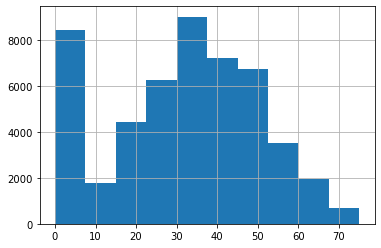

In [61]:
df['len_reviews'].hist()

In [62]:
# посчитаем сколько в среднем приходится букв на один отзыв
num_letter = df.query('len_reviews >0')['len_reviews'].sum(
)/df[df['reviews_new_list'] != 'Unknown']['reviews_new_list'].sum()
num_letter

18.317709801710365

/Users/evgeny/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


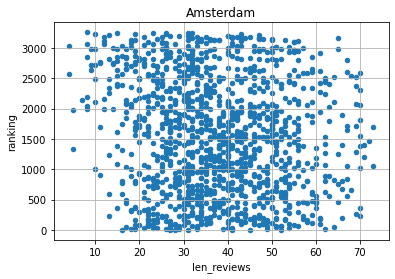

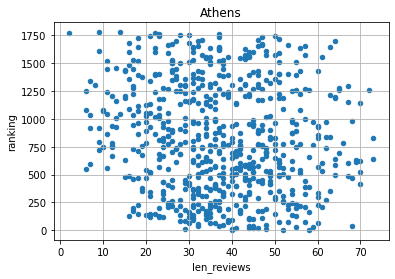

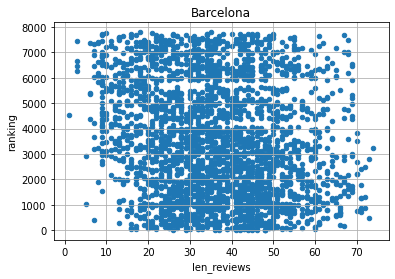

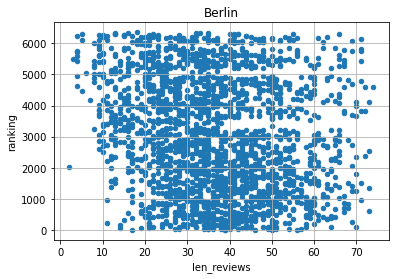

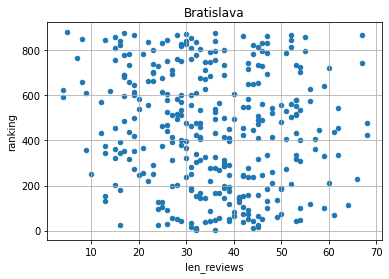

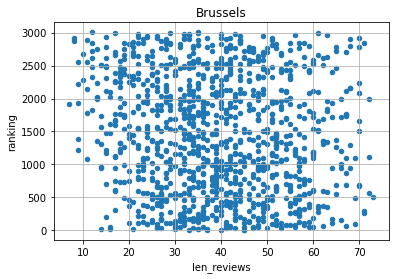

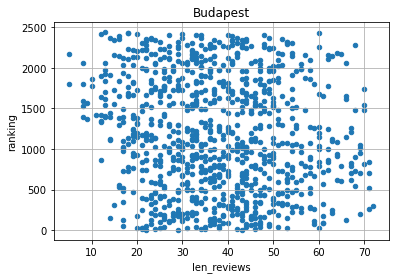

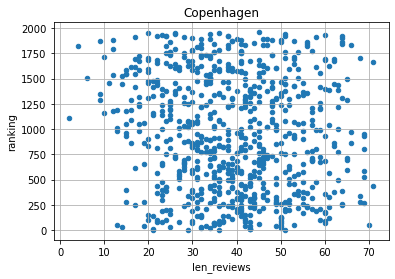

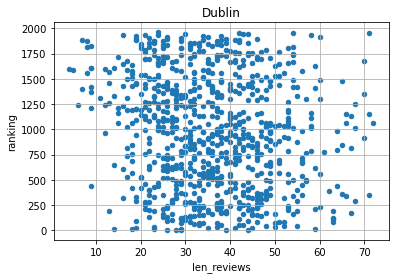

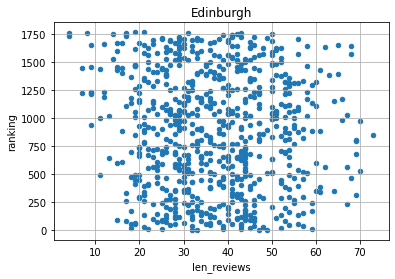

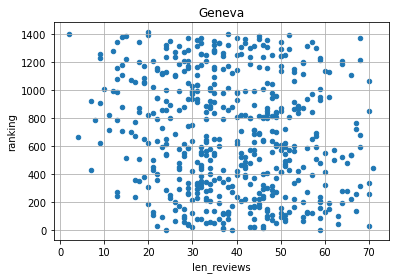

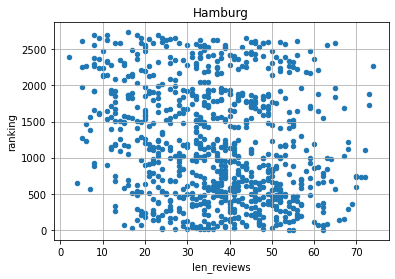

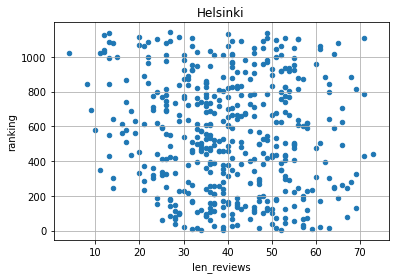

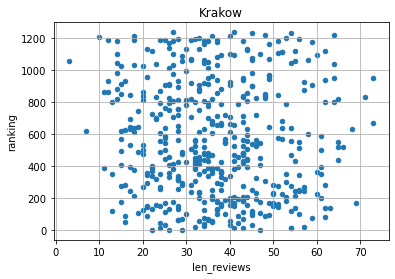

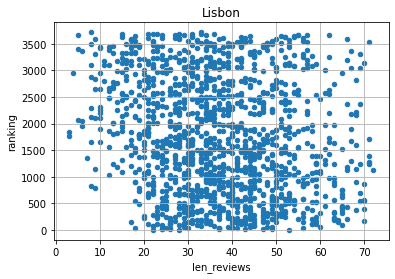

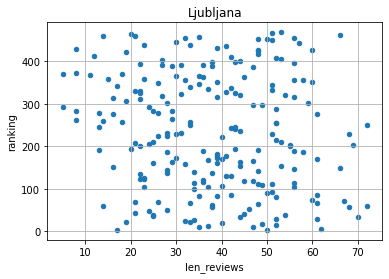

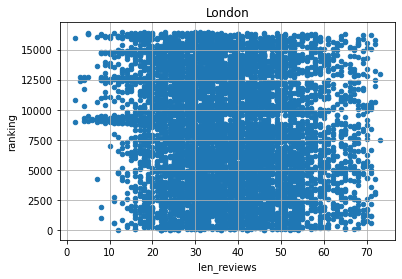

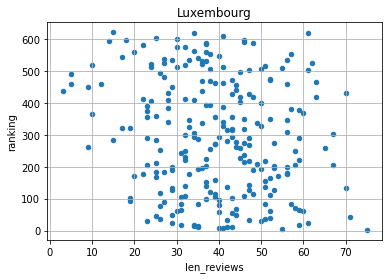

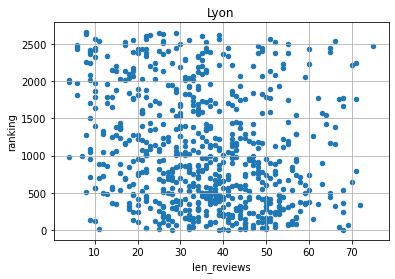

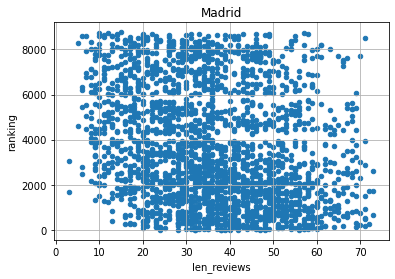

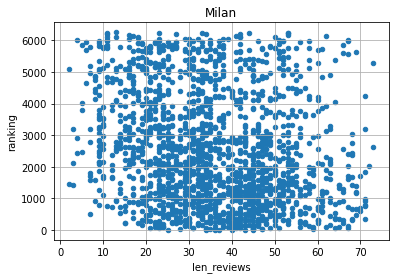

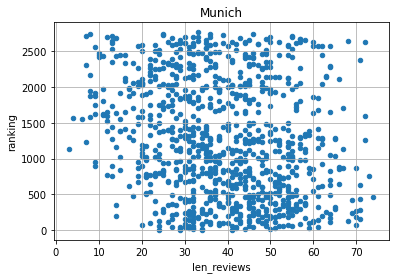

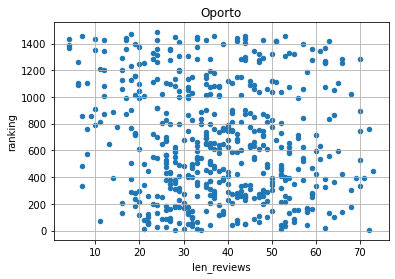

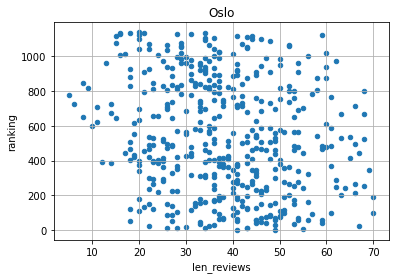

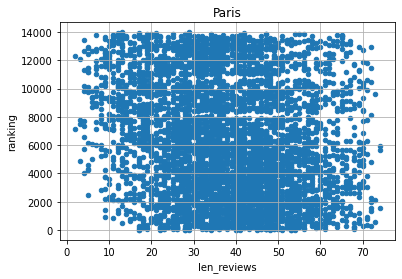

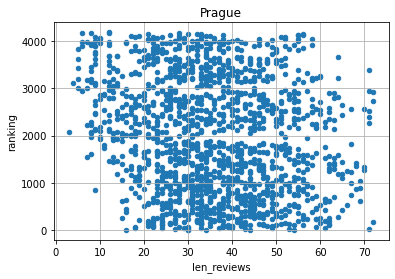

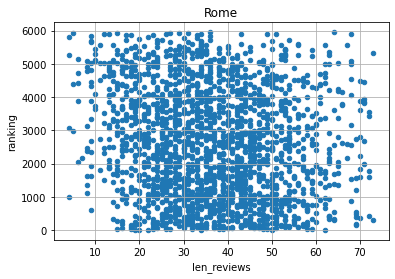

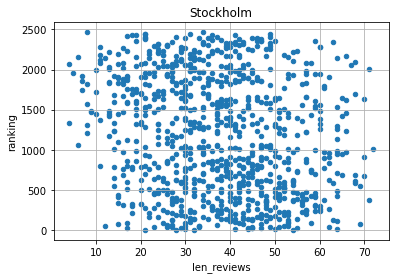

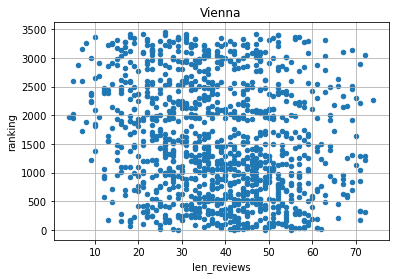

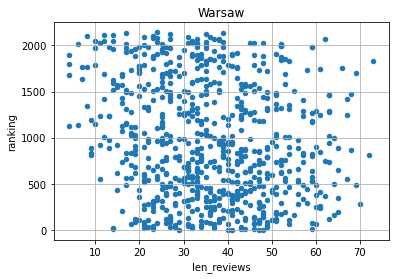

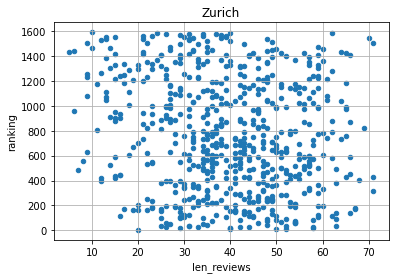

In [63]:
# посмотрим на распределение len_reviews относительно ранжирования
for i in city_list:
    df[(df['len_reviews'] != 0) & (df['city'] == i)].plot(x='len_reviews',
                                                                       y='ranking',
                                                                       kind='scatter',
                                                                       grid=True,
                                                                       title=i
                                                                       )

In [64]:
# заполним нули num_letter * reviews_new_list
df.loc[(df['len_reviews'] == 0) & (df['reviews_new_list'] != 0),
       'len_reviews'] = df['reviews_new_list']*num_letter

In [65]:
MAE: 0.180875

### City

In [66]:
# имеет смысл выделить столицу
capital = ['Vienna',
'Brussels',
'Prague',
'Copenhagen',
'Helsinki',
'Paris',
'Berlin',
'Athens',
'Budapest',
'Dublin',
'Rome',
'Luxembourg',
'Amsterdam',
'Oslo',
'Warsaw',
'Lisbon',
'Bratislava',
'Ljubljana',
'Madrid',
'Stockholm',
'London']
# создадим дополнительный столбец capital == 1, no capital == 0
df['capital'] = df.city.apply(lambda x: 0 if x not in capital else 1 )
add_new_f('capital')

In [67]:
df['capital'].value_counts()

1    37238
0    12762
Name: capital, dtype: int64

In [68]:
df[df['capital']==0].city.unique()

array(['Edinburgh', 'Milan', 'Munich', 'Hamburg', 'Barcelona', 'Lyon',
       'Oporto', 'Krakow', 'Zurich', 'Geneva'], dtype=object)

In [69]:
# проверим есть ли ошибки в назначении города на основании url_ta
pattern = re.compile('[g]\d+')
pattern.findall(df.url_ta[0])
df['city_code'] = df.url_ta.apply(lambda x: pattern.findall(x)[0])

add_new_f('city_code')

df['city_code'].value_counts()

g186338     7193
g187147     6108
g187514     3813
g187497     3395
g187323     2705
            ... 
g950783        2
g1439609       1
g1080936       1
g6919449       1
g3284927       1
Name: city_code, Length: 74, dtype: int64

In [70]:
# видно, что некоторые коды городов являются уникальными
# посмотрим на сколько разнятся значения
len(df['city_code'].value_counts())- len(df['city'].value_counts())

43

In [71]:
df[df.city_code == "g950782"]
list(df[df.city_code == "g950782"]['url_ta'])


['/Restaurant_Review-g950782-d3865213-Reviews-Le_Duo-Vorst_Brussels.html',
 '/Restaurant_Review-g950782-d12252409-Reviews-The_Maestro-Vorst_Brussels.html']

после анализа кодов города, становится ясным, что коды деляться по расположению ресторана центр или пригород

In [72]:
# создадим дополнительный столбец центр или пригород ubication center == 1, neighborhood == 0
df_code =  pd.DataFrame(df['city_code'].value_counts()<76)
region_list = df_code.index[df_code['city_code']].tolist()
df['center'] = df.city_code.apply(lambda x: 1 if x not in region_list else 0)
add_new_f('center')

In [73]:
df['center'].value_counts()

1    49311
0      689
Name: center, dtype: int64

In [74]:
MAE: 0.181625

Показатель ухудшился

### Посмотрим на cuisine_style


In [75]:
df.cuisine_style_new

0                                               [Bar, Pub]
1        [European, Scandinavian, Gluten Free Options, ...
2                                    [Vegetarian Friendly]
3        [Italian, Mediterranean, European, Vegetarian ...
4        [Italian, Mediterranean, European, Seafood, Ve...
                               ...                        
49995    [Italian, Vegetarian Friendly, Vegan Options, ...
49996    [French, American, Bar, European, Vegetarian F...
49997                                    [Japanese, Sushi]
49998    [Polish, European, Eastern European, Central E...
49999                                            [Spanish]
Name: cuisine_style_new, Length: 50000, dtype: object

In [76]:
# создадим список всех кухонь
c_list=[]
for i in df['cuisine_style_new']:
    if type(i)!=float:
        for n in i:
            if n not in c_list:
                c_list.append(n)
sorted(c_list)

['Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

создадим рабочий датафрейм для анализа cuisine_style

In [77]:
df_no_null_cuisine = df[['city', 'ranking', 'rating', 'number_reviews_new',
                         'len_reviews', 'cuisine_style_new', 'cuisine_style', 'count_cs', 'capital', 'center']].copy()
df_no_null_cuisine = df_no_null_cuisine.dropna()

In [78]:
df_no_null_cuisine = df_no_null_cuisine.explode('cuisine_style_new')

In [79]:
df_no_null_cuisine.cuisine_style_new.value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Latvian                    1
Xinjiang                   1
Salvadoran                 1
Burmese                    1
Name: cuisine_style_new, Length: 125, dtype: int64

<AxesSubplot:title={'center':'Amsterdam'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Athens'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Barcelona'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Berlin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Bratislava'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Brussels'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Budapest'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Copenhagen'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Dublin'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Edinburgh'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Geneva'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Hamburg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Helsinki'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Krakow'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lisbon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Ljubljana'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'London'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Luxembourg'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Lyon'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Madrid'}, ylabel='Frequency'>

<ipython-input-80-d8038ad0f21f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<AxesSubplot:title={'center':'Milan'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Munich'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oporto'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Oslo'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Paris'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Prague'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Rome'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Stockholm'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Vienna'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Warsaw'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Zurich'}, ylabel='Frequency'>

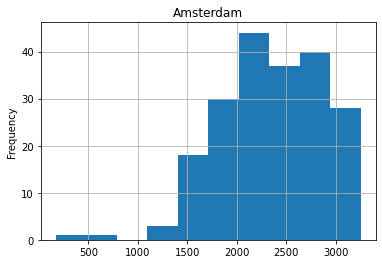

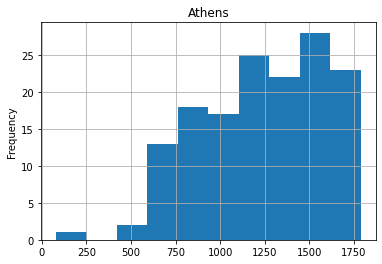

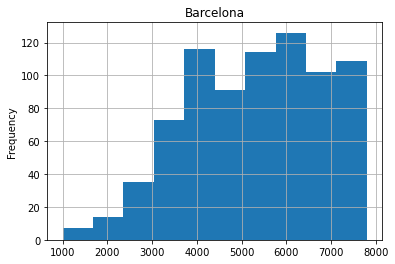

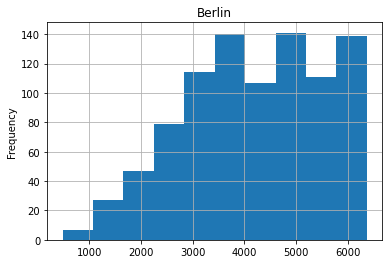

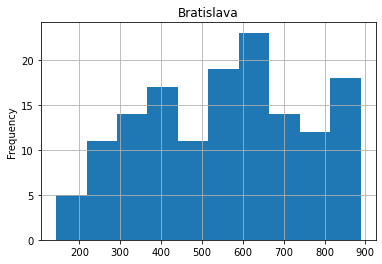

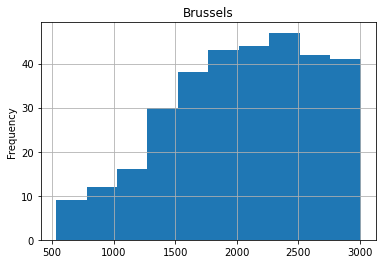

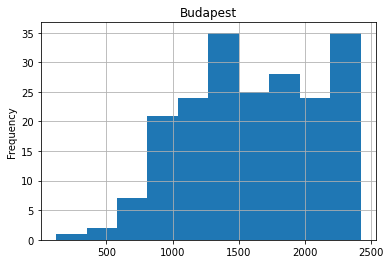

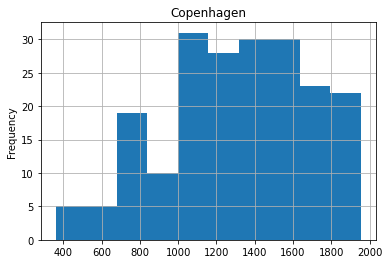

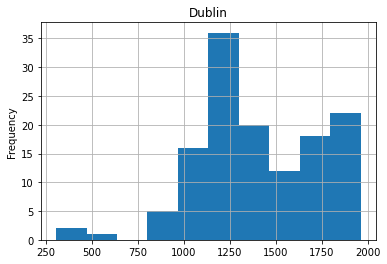

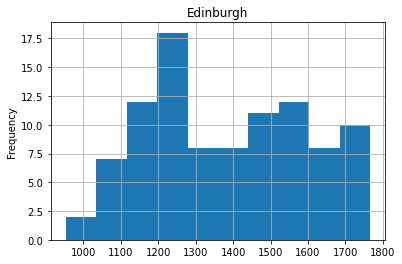

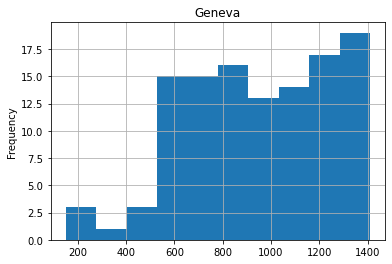

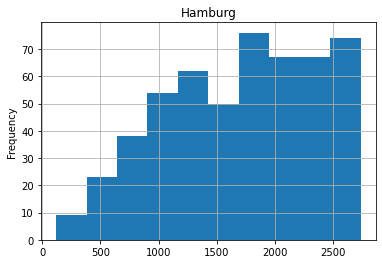

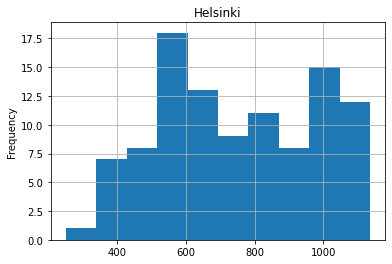

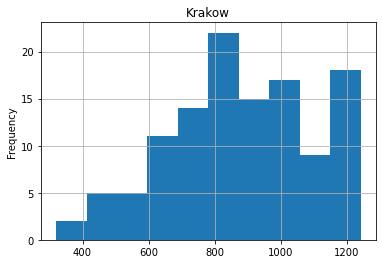

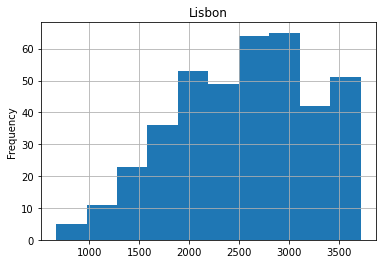

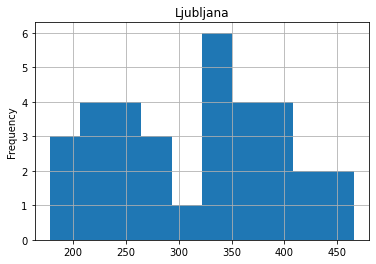

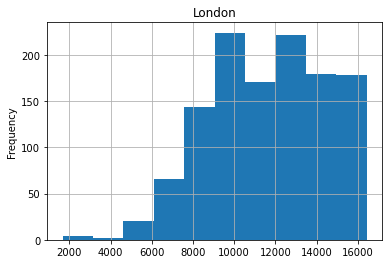

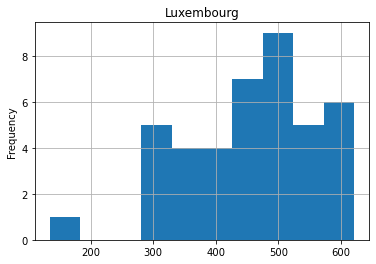

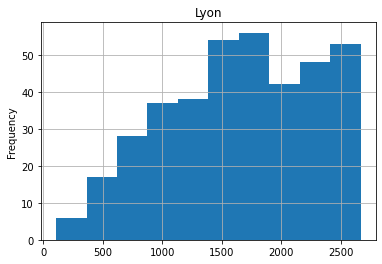

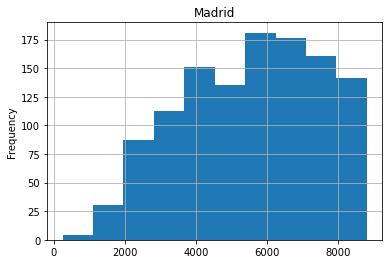

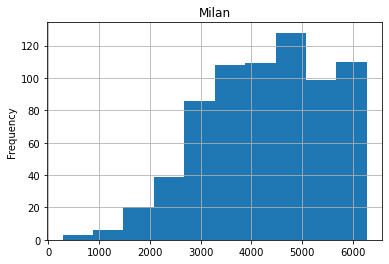

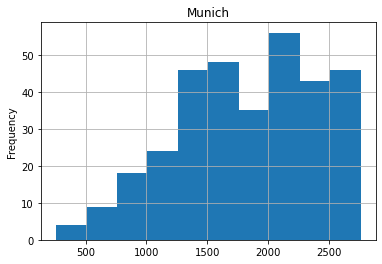

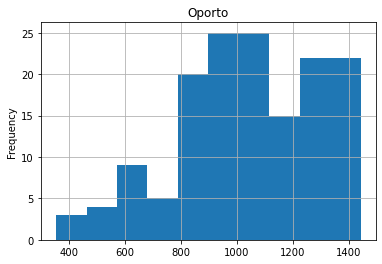

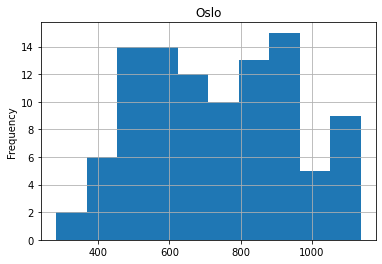

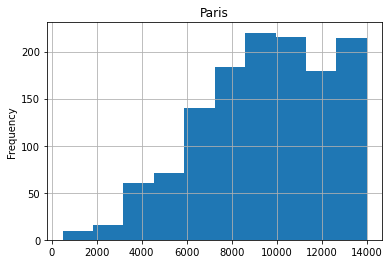

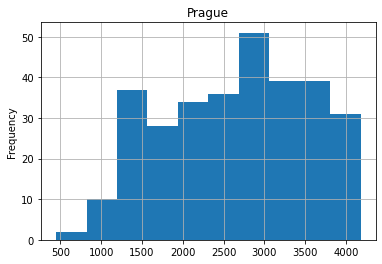

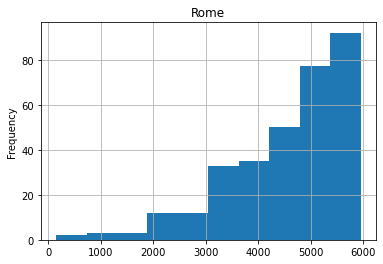

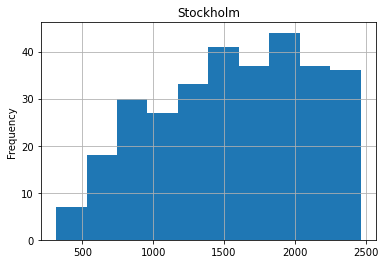

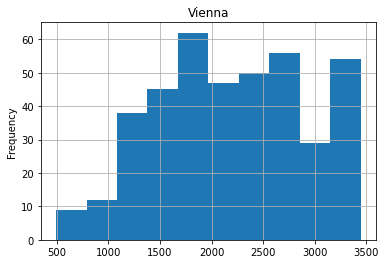

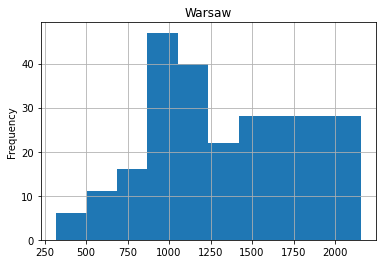

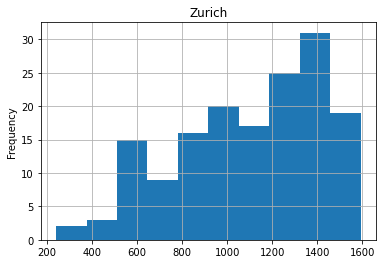

In [80]:
for i in city_list:
    fig, ax = plt.subplots()
    display(df[(df['cuisine_style_new'].isna()) & (df['city'] == i)
               ].ranking.plot(kind='hist', grid=True, title=i))

In [81]:
# заполним пропуски в count_cs на основании ранжирования по городу,взяв соседнии значения
df_fill_count_cs = df.copy()
df_fill_count_cs = df_fill_count_cs.sort_values(['ranking'], ascending=[True])[
    ['ranking', 'count_cs', 'city','unique_id']]

fill_count_cs = pd.DataFrame()
for i in city_list:
    df_reind = 'df_fill_' + i
    df_reind = df_fill_count_cs.sort_values(
        ['ranking'], ascending=[True])[df_fill_count_cs['city'] == i].reset_index().fillna(method='ffill')
    fill_count_cs = pd.concat([fill_count_cs, df_reind])

fill_count_cs['count_cs_new'] = fill_count_cs['count_cs']
fill_count_cs = fill_count_cs.reset_index()[['unique_id','count_cs_new']]
add_new_f('center')


<ipython-input-81-3e82de834cbc>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reind = df_fill_count_cs.sort_values(


Слишком много пропусков, учитывать в модели не будем

In [82]:
fill_count_cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unique_id     50000 non-null  int64  
 1   count_cs_new  50000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


In [83]:
df = df.merge(fill_count_cs, left_on='unique_id', right_on='unique_id')

In [84]:
# заполним пропуски cuisine_style_new, будем основываться на ранкинге и модой по городу

for i in city_list:
    df.loc[(df['city'] == i) & (df['cuisine_style'].isna()),
           'cuisine_style_new'] = df.loc[(df['city'] == i), 'ranking'].apply(
        lambda x: df[(df['city'] == i) & (df['ranking'] > (x - 500)) & (df['ranking'] < (x + 500))].cuisine_style_new.mode()[0])

In [85]:
MAE: 0.189

при заполнении пропусков в count_cs_new и cuisine_style_new и добавлении показатель МАЕ ухудшился

### Новые признаки

In [86]:
# основываясь на ranking создадим признак кол-во ресторанов в городе
df['rest_in_city'] = df['city'].apply(lambda x: df.groupby('city').ranking.max()[x])
add_new_f('rest_in_city')

In [87]:
# создадим признак соотношение ранга ресторана к ресторанам в городе
df['ranking_ratio'] = round(df['ranking']/df['rest_in_city'],3)
add_new_f('ranking_ratio')

In [88]:
MAE: 0.178625

In [89]:
# создадим новое ранжирование
df['rank_new'] = df.groupby('city')['ranking'].rank()
add_new_f('rank_new')

In [90]:
MAE: 0.17925

In [91]:
# создадим новый ранк ресоранов в городе
df['rank_in_city'] = df['city'].apply(lambda x: df.groupby('city')['rank_new'].max()[x])
add_new_f('rank_in_city')

In [92]:
MAE: 0.17775

In [93]:
# создадим признак соотношение нового ранга ресторана к ресторанам в городе
df['ranking_new_ratio'] = round(df['rank_in_city']/df['rank_new'],3)
add_new_f('ranking_new_ratio')


In [94]:
MAE: 0.178875

In [95]:
# создадим новый признак из number_reviews
df['number_reviews_max'] = df['city'].apply(lambda x: df.loc[df['city']== x,'number_reviews'].max())
add_new_f('number_reviews_max')

In [96]:
MAE: 0.17775

In [97]:
# соотношение кол ва отзывов к макс в городе
df['number_reviews_ratio'] = round(df['number_reviews_new']/df['number_reviews_max'],3)
add_new_f('number_reviews_ratio')

In [98]:
MAE: 0.176875

In [99]:
# в date_reviews оставим последний отзыв
df['date_reviews'] = df['date_reviews'].apply(lambda x: max(x) if x!= None else x)

In [100]:
# переведем в datetime
df['date_reviews'] = df['date_reviews'].apply(lambda x: pd.to_datetime(x) if x!=None else x)

<AxesSubplot:>

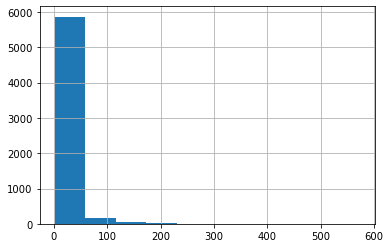

In [101]:
df[df['date_reviews'].isnull()]['number_reviews'].hist()

In [102]:
# призаполнении пропусков будем основываться на кол ве отзывов
# number_reviews х<25, 25<x<75, 100<x<200, 200<x<350, 350<x<600
x_1 = df[(df['number_reviews_new'] < 25)]['date_reviews'].mode()[0]
x_2 = df[(df['number_reviews_new'] > 24) & (
    df['number_reviews_new'] < 75)]['date_reviews'].mode()[0]
x_3 = df[(df['number_reviews_new'] > 100) & (
    df['number_reviews_new'] < 200)]['date_reviews'].mode()[0]
x_4 = df[(df['number_reviews_new'] > 199) & (
    df['number_reviews_new'] < 350)]['date_reviews'].mode()[0]
x_5 = df[(df['number_reviews_new'] > 349) & (
    df['number_reviews_new'] < 600)]['date_reviews'].mode()[0]

In [103]:
df.loc[np.isnat(df['date_reviews']), 'date_reviews'] = df.loc[np.isnat(df['date_reviews']),
    'number_reviews_new'].apply(lambda x: x_1 if x < 25 else x_2 if 24 < x <= 100 
    else x_3 if 100 <= x < 200 else x_4 if 199 < x < 350 else x_5 if 349 < x < 600 else x_1)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   restaurant_id         50000 non-null  object        
 1   city                  50000 non-null  object        
 2   cuisine_style         38410 non-null  object        
 3   ranking               50000 non-null  float64       
 4   price_range           32639 non-null  float64       
 5   number_reviews        46800 non-null  float64       
 6   reviews               49998 non-null  object        
 7   url_ta                50000 non-null  object        
 8   id_ta                 50000 non-null  object        
 9   sample                50000 non-null  int64         
 10  rating                50000 non-null  float64       
 11  cuisine_style_new     50000 non-null  object        
 12  reviews_new           50000 non-null  object        
 13  date_reviews    

In [105]:
# Создаем столбец с Timedelta с момента последнего отзыва
df['days_from_review'] = DT.datetime.today() - df['date_reviews']

In [106]:
type_col(df['date_reviews'])

[pandas._libs.tslibs.timestamps.Timestamp]

In [107]:
# и преобразуем его в количество дней
df['days_from_review'] = df['days_from_review'].map(lambda x: x.days)
add_new_f('days_from_review')

In [108]:
# создадим признак days_from_review / number_reviews_new
df['days_number_reviews'] = df['days_from_review']/df['number_reviews_new']
add_new_f('days_number_reviews')

# Корреляция признаков


<AxesSubplot:>

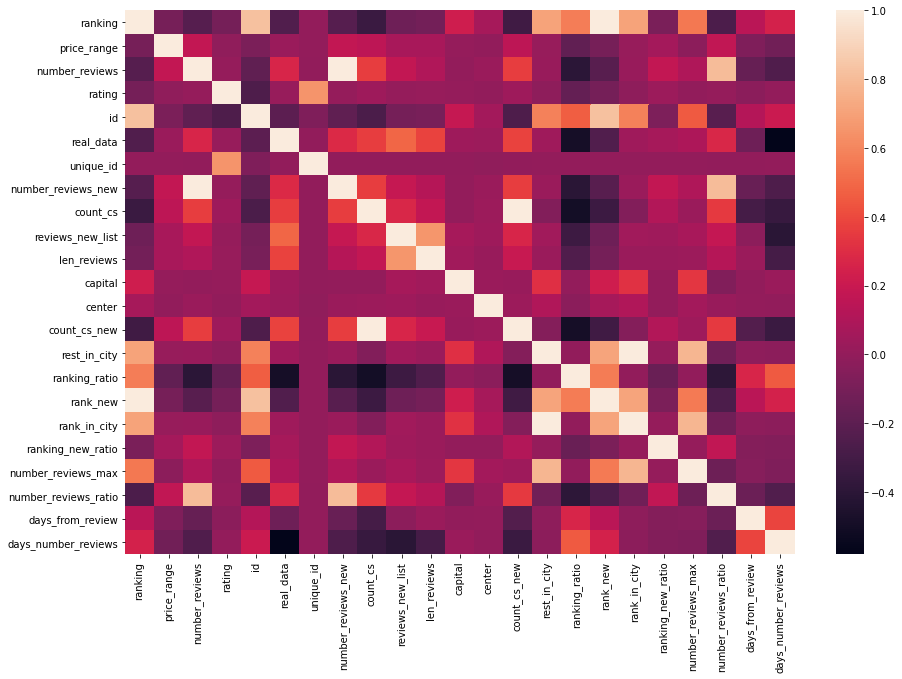

In [125]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr())

In [126]:
df_corr = pd.DataFrame(df.corr())
help_list=[]
for i in df_corr:
    for n in df_corr[i]:
        if df_corr.index[df_corr[i]== n][0] != i:
            if n> 0.6 or n<-0.6:
                if n not in help_list:
                    help_list.append(n)
                    print('Row/Col :','\n',df_corr.index[df_corr[i]== n][0],'/',i,'\n', n,'\n')

Row/Col : 
 id / ranking 
 0.8250898929751174 

Row/Col : 
 rest_in_city / ranking 
 0.7090683633088535 

Row/Col : 
 rank_new / ranking 
 0.9998750300909036 

Row/Col : 
 rank_in_city / ranking 
 0.7090121519268461 

Row/Col : 
 number_reviews_ratio / number_reviews 
 0.8067120507280805 

Row/Col : 
 rating / sample 
 0.93654349570094 

Row/Col : 
 unique_id / sample 
 0.6928203231661385 

Row/Col : 
 unique_id / rating 
 0.6489706280884272 

Row/Col : 
 rank_new / id 
 0.825008975248782 

Row/Col : 
 number_reviews / number_reviews_new 
 1.0 

Row/Col : 
 number_reviews_ratio / number_reviews_new 
 0.808586699333621 

Row/Col : 
 len_reviews / reviews_new_list 
 0.6589711776246938 

Row/Col : 
 rank_new / rest_in_city 
 0.7133031687916848 

Row/Col : 
 rank_in_city / rest_in_city 
 0.9999493789938914 

Row/Col : 
 number_reviews_max / rest_in_city 
 0.7827607394813638 

Row/Col : 
 rank_in_city / rank_new 
 0.7133392787439898 

Row/Col : 
 number_reviews_max / rank_in_city 
 0.783470

При удалении коррелирующих признаков, показатель МАЕ ухудшается. Оставим как есть.

# Data Preprocessing


In [153]:
df_preproc = df.copy()

In [154]:
# Создаем dummies для city
dumm_city = pd.get_dummies(df_preproc['city'])
dumm_city
df_preproc = df_preproc.merge(dumm_city,left_index=True,right_index=True)

In [155]:
# Создаем dummies для cousine_style
mlb = MultiLabelBinarizer()

dumm_cs = pd.DataFrame(mlb.fit_transform(
    df_preproc['cuisine_style_new']), columns=mlb.classes_, index=df_preproc.index)

In [156]:
df_preproc = df_preproc.merge(dumm_cs,left_index=True,right_index=True)

In [157]:
# модель на признаках с нечисловыми "object" данными обучаться не будет, просто выберем их и удалим
object_columns = [
    s for s in df.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis=1, inplace=True)

In [158]:
df_preproc.drop(['unique_id', 'id', 'price_range', 'number_reviews', 'count_cs','capital','center','date_reviews'], axis=1, inplace=True)

In [159]:
df_preproc.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 173 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               50000 non-null  float64
 1   sample                50000 non-null  int64  
 2   rating                50000 non-null  float64
 3   real_data             50000 non-null  float64
 4   number_reviews_new    50000 non-null  float64
 5   reviews_new_list      50000 non-null  int64  
 6   len_reviews           50000 non-null  float64
 7   count_cs_new          50000 non-null  float64
 8   rest_in_city          50000 non-null  float64
 9   ranking_ratio         50000 non-null  float64
 10  rank_new              50000 non-null  float64
 11  rank_in_city          50000 non-null  float64
 12  ranking_new_ratio     50000 non-null  float64
 13  number_reviews_max    50000 non-null  float64
 14  number_reviews_ratio  50000 non-null  float64
 15  days_from_review  

In [145]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [146]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [147]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 

In [148]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [149]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [150]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = np.round(y_pred*2)/2
#y_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [151]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.173375


<AxesSubplot:>

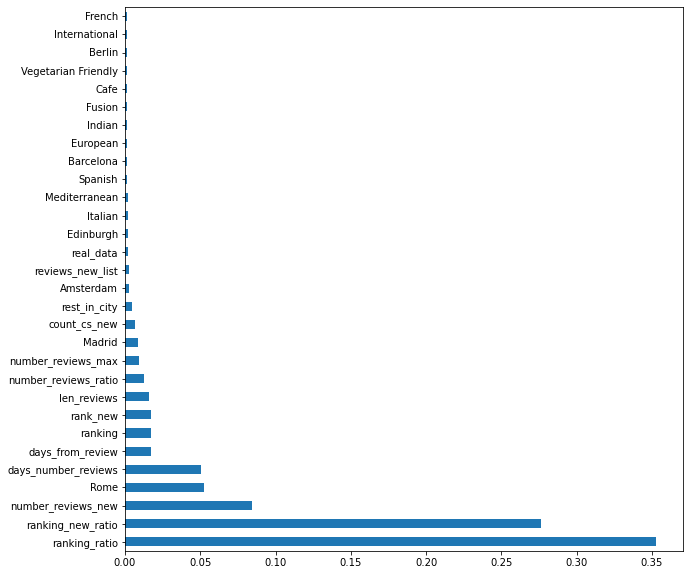

In [152]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

#  Submission

In [440]:
test_data.sample(10)

ranking  rating  real_data  number_reviews_new  reviews_new_list  \
4799   3629.0     0.0        1.0               136.0                 2   
5271     86.0     0.0        1.0              1379.0                 2   
310   16329.0     0.0        0.0                 2.0                 2   
7757   1211.0     0.0        0.0                 3.0                 1   
3687   1037.0     0.0        0.0                11.0                 2   
3894   3353.0     0.0        0.0                 2.0                 1   
5616   4031.0     0.0        1.0               188.0                 2   
235    1662.0     0.0        1.0                 4.0                 2   
7269   3619.0     0.0        1.0                10.0                 2   
5108    836.0     0.0        1.0                23.0                 2   

      len_reviews  rest_in_city  ranking_ratio  rank_new  rank_in_city  ...  \
4799    36.000000        5948.0          0.610    1569.0        2589.0  ...   
5271    23.000000        3254.0          0.026      41.0        1372.0  ...   
310     27.000000       16444.0          0.993    7158.0        7193.0  ...   
7757    18.323737        2440.0          0.496     515.0        1021.0  ...   
3687    24.000000        4188.0          0.248     459.0        1816.0  ...   
3894    18.323737        6372.0          0.526    1379.0        2705.0  ...   
5616    37.000000       13986.0          0.288    1788.0        6108.0  ...   
235     42.000000        4188.0          0.397     718.0        1816.0  ...   
7269    39.000000        6372.0          0.568    1511.0        2705.0  ...   
5108    25.000000        2763.0          0.303     358.0        1145.0  ...   

      Ukrainian  Uzbek  Vegan Options  Vegetarian Friendly  Venezuelan  \
4799          0      0              0                    1           0   
5271          0      0              0                    0           0   
310           0      0              0                    0           0   
7757          0      0              0                    0           0   
3687          0      0              0                    0           0   
3894          0      0              0                    0           0   
5616          0      0              0                    0           0   
235           0      0              0                    0           0   
7269          0      0              0                    0           0   
5108          0      0              0                    0           0   

      Vietnamese  Welsh  Wine Bar  Xinjiang  Yunnan  
4799           0      0         0         0       0  
5271           0      0         0         0       0  
310            0      0         0         0       0  
7757           0      0         0         0       0  
3687           0      0         0         0       0  
3894           0      0         0         0       0  
5616           0      0         0         0       0  
235            0      0         0         0       0  
7269           0      0         0         0       0  
5108           0      0         0         0       0  

[10 rows x 172 columns]

In [441]:
test_data = test_data.drop(['rating'], axis=1)

In [442]:
sample_submission

Restaurant_id  Rating
0             id_0     2.0
1             id_1     2.5
2             id_2     4.0
3             id_3     1.0
4             id_4     4.0
...            ...     ...
9995       id_9995     3.0
9996       id_9996     1.5
9997       id_9997     4.5
9998       id_9998     1.0
9999       id_9999     2.5

[10000 rows x 2 columns]

In [443]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.1s finished


In [444]:
predict_submission = np.round(predict_submission*2)/2
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [445]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

Restaurant_id  Rating
0          id_0     3.0
1          id_1     4.0
2          id_2     4.5
3          id_3     4.5
4          id_4     4.5
5          id_5     4.5
6          id_6     1.0
7          id_7     3.0
8          id_8     4.0
9          id_9     4.5